## Importing Necessary Libraries

In [2]:
import csv
from PIL import Image
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import resize
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, classification_report
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.models import save_model

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Defining Dataset Paths

In [3]:
# dataset_path = r'C:\Users\mdirt\OneDrive\Desktop\Group_5'
# train_image_dir =  r'C:\Users\mdirt\OneDrive\Desktop\Group_5\train'
# test_image_dir =  r'C:\Users\mdirt\OneDrive\Desktop\Group_5\test'

dataset_path = '/content/drive/My Drive/Group_5'
train_image_dir =  '/content/drive/My Drive/Group_5/train'
test_image_dir =  '/content/drive/My Drive/Group_5/test'

## Size of the Dataset

In [4]:
def count_images_in_directory(directory_path):
    count = 0
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
                count += 1
    return count

train_path = os.path.join(dataset_path, 'train')
test_path = os.path.join(dataset_path, 'test')

train_count = count_images_in_directory(train_path)
test_count = count_images_in_directory(test_path)
total_count = train_count + test_count
print("Total Data Count",total_count)
print("Train Data Count",train_count)
print("Test Data Count",test_count)

Total Data Count 2400
Train Data Count 2150
Test Data Count 250


## Loading Dataset

In [5]:
def display_image_from_row(row):
    image_data = row['Image_Data']
    label = row['Labels']
    plt.imshow(image_data)
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()

def to_rgb(image):
    if len(image.shape) == 2:
        return np.stack((image,) * 3, axis=-1)
    return image


filepaths = []
images = []
labels = []

folds = os.listdir(train_image_dir)
for fold in folds:
    foldpath = os.path.join(train_image_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        image_data = np.array(Image.open(fpath))
        image_data = to_rgb(image_data)
        images.append(image_data/255.0)
        labels.append(fold)

ImageSeries = pd.Series(images, name='Image_Data')
LabelSeries = pd.Series(labels, name='Labels')
data_train = pd.concat([ImageSeries, LabelSeries], axis=1)
data_train = data_train.sample(frac=1).reset_index(drop=True)


filepaths = []
images = []
labels = []

folds = os.listdir(test_image_dir)
for fold in folds:
    foldpath = os.path.join(test_image_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        image_data = np.array(Image.open(fpath))
        image_data = to_rgb(image_data)
        images.append(image_data/255.0)
        labels.append(fold)

ImageSeries = pd.Series(images, name='Image_Data')
LabelSeries = pd.Series(labels, name='Labels')
data_test = pd.concat([ImageSeries, LabelSeries], axis=1)
data_test = data_test.sample(frac=1).reset_index(drop=True)
# display_image_from_row(data_train.iloc[0])
# print(data_train.iloc[0])
data_train

,Image_Data,Labels
0,"[[[0.9607843137254902, 0.8313725490196079, 0.5...",pill-bottle
1,"[[[0.5647058823529412, 0.5882352941176471, 0.6...",projectile
2,"[[[0.5254901960784314, 0.8235294117647058, 0.4...",pill-bottle
3,"[[[0.6431372549019608, 0.6666666666666666, 0.6...",snail
4,"[[[0.35294117647058826, 0.39215686274509803, 0...",projectile
...,...,...
2145,"[[[0.06274509803921569, 0.07058823529411765, 0...",pill-bottle
2146,"[[[0.3215686274509804, 0.3686274509803922, 0.1...",snail
2147,"[[[0.5294117647058824, 0.6078431372549019, 0.3...",projectile
2148,"[[[0.9294117647058824, 0.9372549019607843, 0.9...",fence


## Separating Train and Validation Data

In [6]:
train_data, validation_data = train_test_split(data_train, test_size=0.20, random_state=42)
print("Training Data Count", train_data.shape)
print("Validation Data Count", validation_data.shape)

Training Data Count (1720, 2)
Validation Data Count (430, 2)


## Number of Samples Per Class

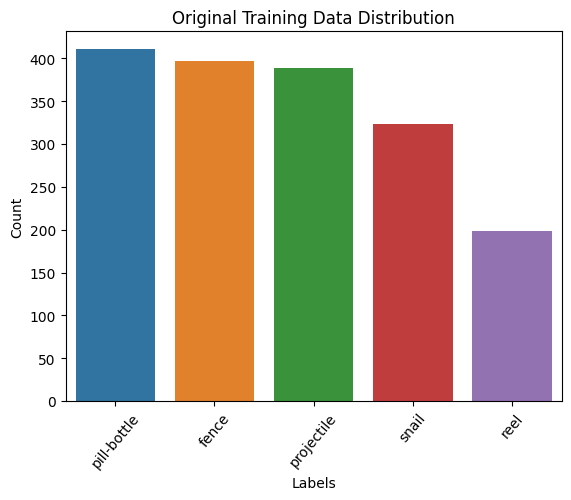

In [7]:
counts = train_data.Labels.value_counts()
plt.title('Original Training Data Distribution')
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=50);

## Undersampling and Oversampling the Training Data

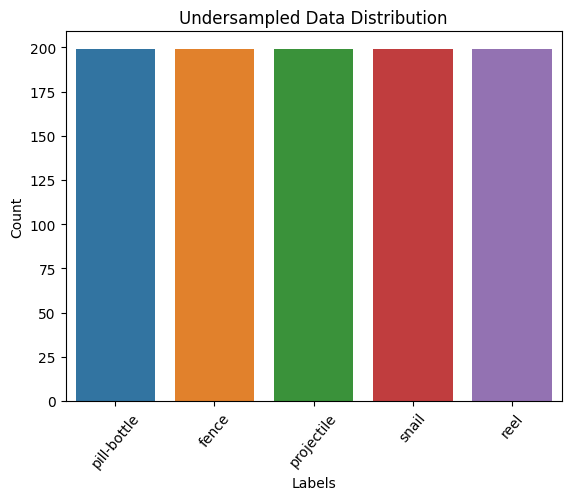

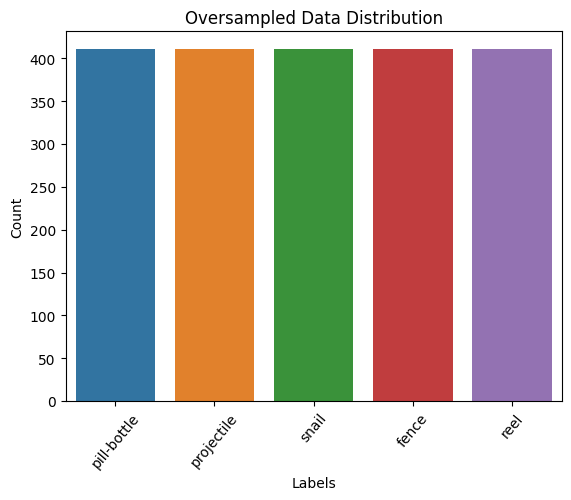

In [8]:
minority_class_count = counts.min()
majority_class_count = counts.max()

undersampled_data = pd.DataFrame()
for label in counts.index:
    label_data = data_train[data_train['Labels'] == label]
    resampled_label_data = resample(label_data,
                                    replace=False,
                                    n_samples=minority_class_count,
                                    random_state=42)
    undersampled_data = pd.concat([undersampled_data, resampled_label_data])


oversampled_data = pd.DataFrame()
for label in data_train['Labels'].unique():
    label_data = data_train[data_train['Labels'] == label]
    resampled_label_data = resample(label_data,
                                    replace=True,
                                    n_samples=majority_class_count,
                                    random_state=42)
    oversampled_data = pd.concat([oversampled_data, resampled_label_data])

oversampled_data.reset_index(drop=True, inplace=True)


new_counts = undersampled_data['Labels'].value_counts()
sns.barplot(x=new_counts.index, y=new_counts.values)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Undersampled Data Distribution')
plt.xticks(rotation=50)
plt.show()

new_counts_over = oversampled_data['Labels'].value_counts()
sns.barplot(x=new_counts_over.index, y=new_counts_over.values)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Oversampled Data Distribution')
plt.xticks(rotation=50)
plt.show()

## Oversampling the Training Data using Augmentations

Original Image:


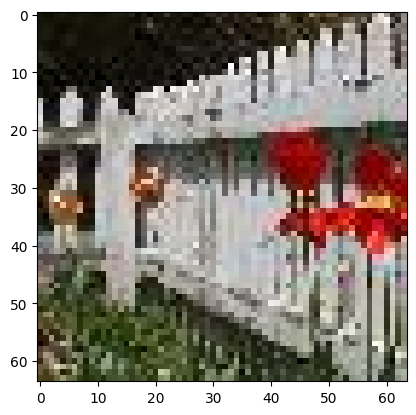

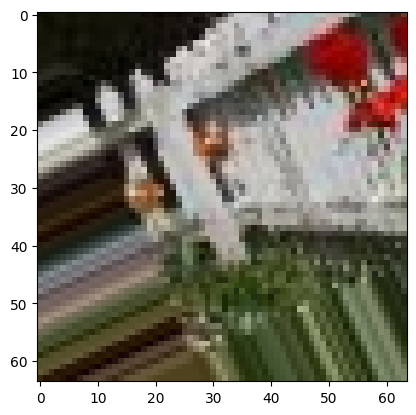

Augmented Image


In [9]:
labels = train_data['Labels']

label_to_index = {label: index for index, label in enumerate(np.unique(labels))}
train_data['Label_Index'] = train_data['Labels'].map(label_to_index)

class_sample_count = train_data['Label_Index'].value_counts().to_dict()
max_samples = max(class_sample_count.values())

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0,
    horizontal_flip=True,
    fill_mode='nearest'
)

x = 5
def augment_image(image_array, num_required):
    global x
    if image_array.max() <= 1:
        image_array = (image_array * 255).astype(np.uint8)

    image_array = image_array.astype(np.float32) / 255.0

    if x <=5:
      print("Original Image:")
      plt.imshow(image_array)
      plt.show()

    image = np.expand_dims(image_array, 0)
    aug_iter = datagen.flow(image)
    aug_images = []

    for i in range(num_required):
        aug_image = next(aug_iter)[0]
        aug_image = (aug_image * 255).astype(np.uint8)
        aug_images.append(aug_image)

        if x <=5:
          plt.imshow(aug_image)
          plt.show()
          print(f"Augmented Image")
          x += 1
    return aug_images


samples_to_add_per_class = {label: max_samples - count for label, count in class_sample_count.items()}

balanced_data = []
for label, num_required in samples_to_add_per_class.items():
    class_samples = train_data[train_data['Label_Index'] == label]['Image_Data'].sample(n=num_required, replace=True)
    for image_array in class_samples:
        augmented_images = augment_image(image_array, 1)
        for img in augmented_images:
            balanced_data.append({'Image_Data': img, 'Labels': label})

augmented_df = pd.DataFrame(balanced_data)
augmented_df['Labels'] = augmented_df['Labels'].map({v: k for k, v in label_to_index.items()})

balanced_train_data = pd.concat([train_data.drop('Label_Index', axis=1), augmented_df])
# new_class_sample_count = new_train_data['Labels'].value_counts().to_dict()
# print(new_class_sample_count)

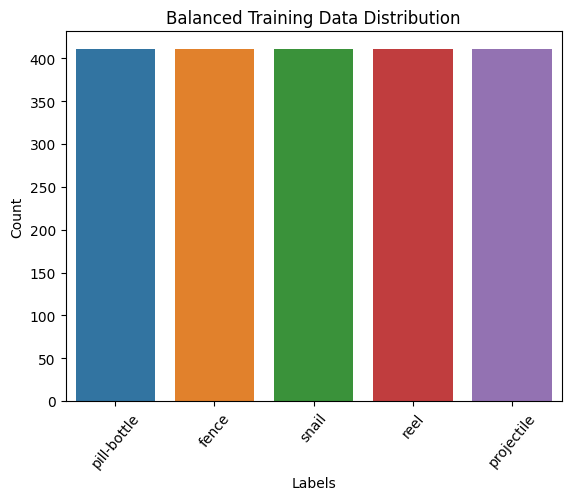

In [10]:
counts = balanced_train_data['Labels'].value_counts()
plt.title('Balanced Training Data Distribution')
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=50);

## Spliting the Data

In [11]:
X_train = []
for idx in range(len(train_data)):
    image_data = train_data.iloc[idx]['Image_Data']
    X_train.append(image_data)


X_train = [to_rgb(img) for img in X_train]
X_train = np.array(X_train)
y_train = np.array(train_data['Labels'].tolist())


X_train_balanced = []
for idx in range(len(balanced_train_data)):
    image_data = balanced_train_data.iloc[idx]['Image_Data']
    X_train_balanced.append(image_data)

X_train_balanced = [to_rgb(img) for img in X_train_balanced]
X_train_balanced = np.array(X_train_balanced)
y_train_balanced = np.array(balanced_train_data['Labels'].tolist())

X_val = []
for idx in range(len(validation_data)):
    image_data = validation_data.iloc[idx]['Image_Data']
    X_val.append(image_data)

X_val = [to_rgb(img) for img in X_val]
X_val = np.array(X_val)
y_val = np.array(validation_data['Labels'].tolist())

X_test = []
for idx in range(len(data_test)):
    image_data = data_test.iloc[idx]['Image_Data']
    X_test.append(image_data)
X_test = [to_rgb(img) for img in X_test]
X_test = np.array(X_test)
y_test = np.array(data_test['Labels'].tolist())

## Flating the Data

In [12]:
scaler = StandardScaler()
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_train_balanced_flat = X_train_balanced.reshape((X_train_balanced.shape[0], -1))
X_test_flat = X_test.reshape((X_test.shape[0], -1))
X_val_flat = X_val.reshape((X_val.shape[0], -1))

In [13]:
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))
y_train_balanced_encoded = encoder.fit_transform(y_train_balanced.reshape(-1, 1))
y_val_encoded = encoder.transform(y_val.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.reshape(-1, 1))

In [14]:
def print_custom_metrics(y_true, y_pred, classes):
    for i, class_name in enumerate(classes):
        sensitivity = recall_score(y_true, y_pred, labels=[i], average='weighted')
        ppv = precision_score(y_true, y_pred, labels=[i], average='weighted')

        print(f"\n{class_name.capitalize()}:")
        print(f"Sensitivity (Recall): {sensitivity:.3f}")
        print(f"PPV (Precision): {ppv:.3f}")
classes = ["fence", "pill-bottle", "projectile", "reel", "snail"]

## Application of Logistic Regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Set Metrics:
Accuracy: 0.9281609195402298


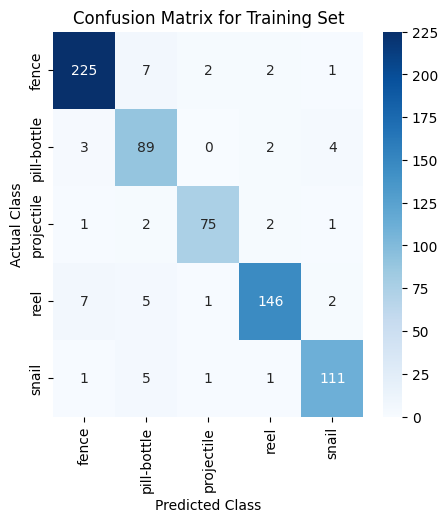

Classification Report:
               precision    recall  f1-score   support

       fence       0.95      0.95      0.95       237
 pill-bottle       0.82      0.91      0.86        98
  projectile       0.95      0.93      0.94        81
        reel       0.95      0.91      0.93       161
       snail       0.93      0.93      0.93       119

    accuracy                           0.93       696
   macro avg       0.92      0.92      0.92       696
weighted avg       0.93      0.93      0.93       696

         Class  Sensitivity (Recall)  PPV (Precision)  Specificity       NPV
0        fence              0.949367         0.949367     0.973856  0.973856
1  pill-bottle              0.908163         0.824074     0.968227  0.984694
2   projectile              0.925926         0.949367     0.993496  0.990276
3         reel              0.906832         0.954248     0.986916  0.972376
4        snail              0.932773         0.932773     0.986135  0.986135

Test Set Metrics:
Accura

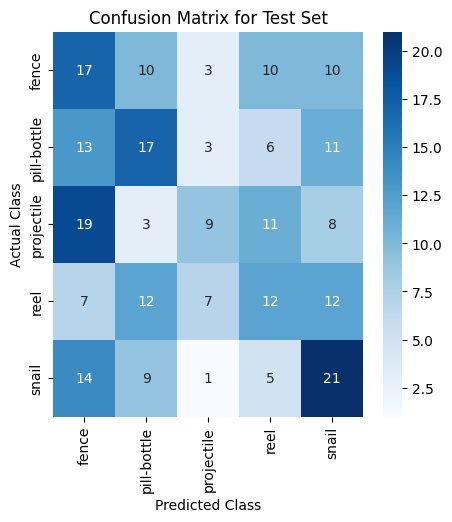

Classification Report:
               precision    recall  f1-score   support

       fence       0.24      0.34      0.28        50
 pill-bottle       0.33      0.34      0.34        50
  projectile       0.39      0.18      0.25        50
        reel       0.27      0.24      0.26        50
       snail       0.34      0.42      0.38        50

    accuracy                           0.30       250
   macro avg       0.32      0.30      0.30       250
weighted avg       0.32      0.30      0.30       250

         Class  Sensitivity (Recall)  PPV (Precision)  Specificity       NPV
0        fence                  0.34         0.242857        0.735  0.816667
1  pill-bottle                  0.34         0.333333        0.830  0.834171
2   projectile                  0.18         0.391304        0.930  0.819383
3         reel                  0.24         0.272727        0.840  0.815534
4        snail                  0.42         0.338710        0.795  0.845745


In [30]:
# Unbalanced
model = LogisticRegression(max_iter=50)
model.fit(X_train_flat, y_train)

train_predictions = model.predict(X_train_flat)
test_predictions = model.predict(X_test_flat)

def calculate_multiclass_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=["fence", "pill-bottle", "projectile", "reel", "snail"])
    classes = ["fence", "pill-bottle", "projectile", "reel", "snail"]
    specificity = np.zeros(len(classes))
    npv = np.zeros(len(classes))
    class_report = classification_report(y_true, y_pred, labels=classes, output_dict=True)

    metrics_data = []

    for i, class_label in enumerate(classes):
        TN = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        FP = cm[:, i].sum() - cm[i, i]
        FN = cm[i, :].sum() - cm[i, i]

        specificity_val = TN / (TN + FP) if (TN + FP) != 0 else 0
        npv_val = TN / (TN + FN) if (TN + FN) != 0 else 0

        metrics_data.append({
            "Class": class_label,
            "Sensitivity (Recall)": class_report[class_label]['recall'],
            "PPV (Precision)": class_report[class_label]['precision'],
            "Specificity": specificity_val,
            "NPV": npv_val
        })

    metrics_df = pd.DataFrame(metrics_data)
    print(metrics_df)


print("Training Set Metrics:")
print("Accuracy:", accuracy_score(y_train, train_predictions))
cm = confusion_matrix(y_train, train_predictions)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["fence", "pill-bottle", "projectile", "reel", "snail"], yticklabels=["fence", "pill-bottle", "projectile", "reel", "snail"])
plt.title('Confusion Matrix for Training Set')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()
print("Classification Report:\n", classification_report(y_train, train_predictions))
calculate_multiclass_metrics(y_train, train_predictions)

print("\nTest Set Metrics:")
print("Accuracy:", accuracy_score(y_test, test_predictions))
cm_test = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(5, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=["fence", "pill-bottle", "projectile", "reel", "snail"], yticklabels=["fence", "pill-bottle", "projectile", "reel", "snail"])
plt.title('Confusion Matrix for Test Set')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()
print("Classification Report:\n", classification_report(y_test, test_predictions))
calculate_multiclass_metrics(y_test, test_predictions)

logistic_unbalanced_metrics = {
    "Train Accuracy":  accuracy_score(y_train, train_predictions) * 100,
    "Test Accuracy": accuracy_score(y_test, test_predictions) * 100,
    "Precision": precision_score(y_test, test_predictions, average='weighted') * 100,
    "Recall": recall_score(y_test, test_predictions, average='weighted') * 100,
    "F1-Score": f1_score(y_test, test_predictions, average='weighted') * 100
}

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Set Metrics:
Accuracy: 0.5274261603375527


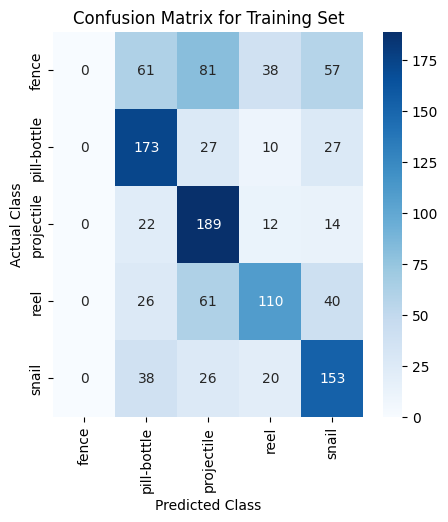

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Classification Report:
               precision    recall  f1-score   support

       fence       0.00      0.00      0.00       237
 pill-bottle       0.54      0.73      0.62       237
  projectile       0.49      0.80      0.61       237
        reel       0.58      0.46      0.52       237
       snail       0.53      0.65      0.58       237

    accuracy                           0.53      1185
   macro avg       0.43      0.53      0.46      1185
weighted avg       0.43      0.53      0.46      1185

         Class  Sensitivity (Recall)  PPV (Precision)  Specificity       NPV
0        fence              0.000000         0.000000     1.000000  0.800000
1  pill-bottle              0.729958         0.540625     0.844937  0.926012
2   projectile              0.797468         0.492188     0.794304  0.940075
3         reel              0.464135         0.578947     0.915612  0.872362
4        snail              0.645570         0.525773     0.854430  0.906040

Test Set Metrics:
Accura

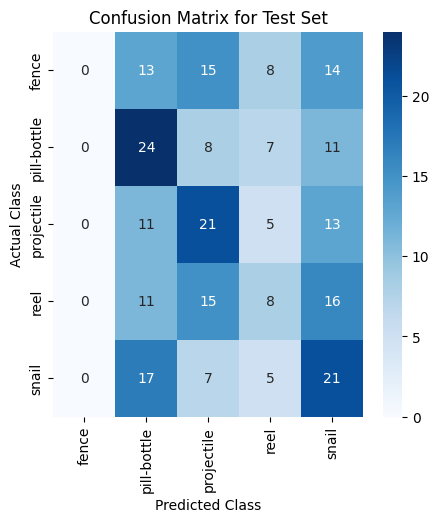

Classification Report:
               precision    recall  f1-score   support

       fence       0.00      0.00      0.00        50
 pill-bottle       0.32      0.48      0.38        50
  projectile       0.32      0.42      0.36        50
        reel       0.24      0.16      0.19        50
       snail       0.28      0.42      0.34        50

    accuracy                           0.30       250
   macro avg       0.23      0.30      0.25       250
weighted avg       0.23      0.30      0.25       250

         Class  Sensitivity (Recall)  PPV (Precision)  Specificity       NPV
0        fence                  0.00         0.000000        1.000  0.800000
1  pill-bottle                  0.48         0.315789        0.740  0.850575
2   projectile                  0.42         0.318182        0.775  0.842391
3         reel                  0.16         0.242424        0.875  0.806452
4        snail                  0.42         0.280000        0.730  0.834286


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [31]:
# Balanced
model = LogisticRegression(max_iter=50)
model.fit(X_train_balanced_flat, y_train_balanced)

train_predictions = model.predict(X_train_balanced_flat)
test_predictions = model.predict(X_test_flat)

def calculate_multiclass_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=["fence", "pill-bottle", "projectile", "reel", "snail"])
    classes = ["fence", "pill-bottle", "projectile", "reel", "snail"]
    specificity = np.zeros(len(classes))
    npv = np.zeros(len(classes))
    class_report = classification_report(y_true, y_pred, labels=classes, output_dict=True)

    metrics_data = []

    for i, class_label in enumerate(classes):
        TN = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        FP = cm[:, i].sum() - cm[i, i]
        FN = cm[i, :].sum() - cm[i, i]

        specificity_val = TN / (TN + FP) if (TN + FP) != 0 else 0
        npv_val = TN / (TN + FN) if (TN + FN) != 0 else 0

        metrics_data.append({
            "Class": class_label,
            "Sensitivity (Recall)": class_report[class_label]['recall'],
            "PPV (Precision)": class_report[class_label]['precision'],
            "Specificity": specificity_val,
            "NPV": npv_val
        })

    metrics_df = pd.DataFrame(metrics_data)
    print(metrics_df)


print("Training Set Metrics:")
print("Accuracy:", accuracy_score(y_train_balanced, train_predictions))
cm = confusion_matrix(y_train_balanced, train_predictions)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["fence", "pill-bottle", "projectile", "reel", "snail"], yticklabels=["fence", "pill-bottle", "projectile", "reel", "snail"])
plt.title('Confusion Matrix for Training Set')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()
print("Classification Report:\n", classification_report(y_train_balanced, train_predictions))
calculate_multiclass_metrics(y_train_balanced, train_predictions)

print("\nTest Set Metrics:")
print("Accuracy:", accuracy_score(y_test, test_predictions))
cm_test = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(5, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=["fence", "pill-bottle", "projectile", "reel", "snail"], yticklabels=["fence", "pill-bottle", "projectile", "reel", "snail"])
plt.title('Confusion Matrix for Test Set')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()
print("Classification Report:\n", classification_report(y_test, test_predictions))
calculate_multiclass_metrics(y_test, test_predictions)

# Metrics calculation
logistic_balanced_metrics = {
    # "Train Accuracy":  accuracy_score(y_train, train_predictions) * 100,
    "Test Accuracy": accuracy_score(y_test, test_predictions) * 100,
    "Precision": precision_score(y_test, test_predictions, average='weighted') * 100,
    "Recall": recall_score(y_test, test_predictions, average='weighted') * 100,
    "F1-Score": f1_score(y_test, test_predictions, average='weighted') * 100
}

## Application of Neural Network

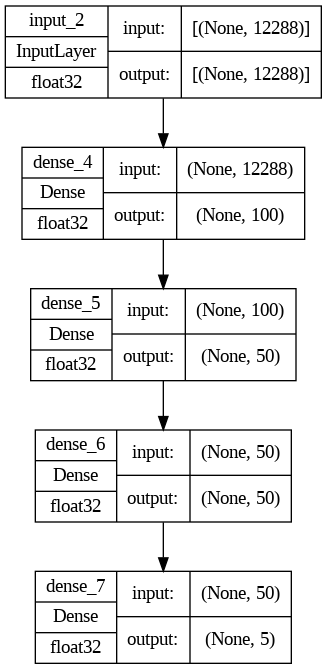

In [32]:
model = Sequential()
model.add(Input(shape=(X_train_flat.shape[1],)))
model.add(Dense(100, activation='sigmoid'))
model.add(Dense(50, activation='sigmoid'))
model.add(Dense(50, activation='sigmoid'))
model.add(Dense(y_train_encoded.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True)

Epoch 1/100
11/11 [==============================] - 2s 25ms/step - loss: 1.6082 - accuracy: 0.2845 - val_loss: 1.5341 - val_accuracy: 0.3621
Epoch 2/100
11/11 [==============================] - 0s 9ms/step - loss: 1.5415 - accuracy: 0.3405 - val_loss: 1.5143 - val_accuracy: 0.3621
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 1.5359 - accuracy: 0.3405 - val_loss: 1.5130 - val_accuracy: 0.3621
Epoch 4/100
11/11 [==============================] - 0s 10ms/step - loss: 1.5336 - accuracy: 0.3405 - val_loss: 1.5147 - val_accuracy: 0.3621
Epoch 5/100
11/11 [==============================] - 0s 9ms/step - loss: 1.5338 - accuracy: 0.3405 - val_loss: 1.5156 - val_accuracy: 0.3621
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 1.5321 - accuracy: 0.3405 - val_loss: 1.5119 - val_accuracy: 0.3621
Epoch 7/100
11/11 [==============================] - 0s 7ms/step - loss: 1.5296 - accuracy: 0.3405 - val_loss: 1.5121 - val_accuracy: 0.3621
Epoch 8/100

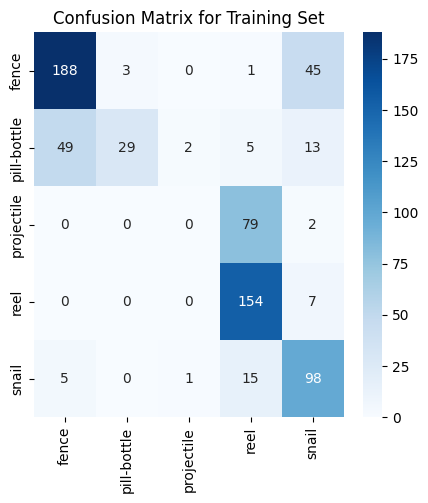

Classification Report for Training Set:
              precision    recall  f1-score   support

       fence       0.78      0.79      0.78       237
 pill-bottle       0.91      0.30      0.45        98
  projectile       0.00      0.00      0.00        81
        reel       0.61      0.96      0.74       161
       snail       0.59      0.82      0.69       119

    accuracy                           0.67       696
   macro avg       0.58      0.57      0.53       696
weighted avg       0.63      0.67      0.62       696


Custom Metrics for Training Set:

Fence:
Sensitivity (Recall): 0.793
PPV (Precision): 0.777

Pill-bottle:
Sensitivity (Recall): 0.296
PPV (Precision): 0.906

Projectile:
Sensitivity (Recall): 0.000
PPV (Precision): 0.000

Reel:
Sensitivity (Recall): 0.957
PPV (Precision): 0.606

Snail:
Sensitivity (Recall): 0.824
PPV (Precision): 0.594
8/8 [==============================] - 0s 3ms/step - loss: 2.2794 - accuracy: 0.2480

Test Accuracy: 0.24799999594688416
8/8 [======

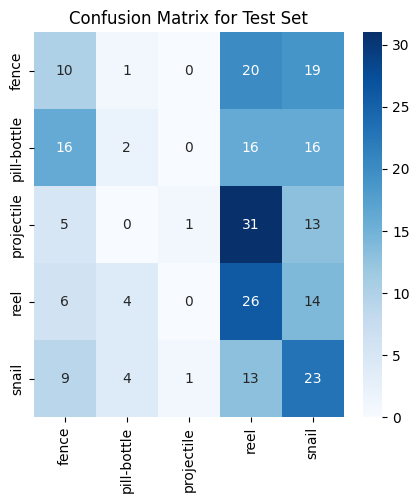

Classification Report for Test Set:
              precision    recall  f1-score   support

       fence       0.22      0.20      0.21        50
 pill-bottle       0.18      0.04      0.07        50
  projectile       0.50      0.02      0.04        50
        reel       0.25      0.52      0.33        50
       snail       0.27      0.46      0.34        50

    accuracy                           0.25       250
   macro avg       0.28      0.25      0.20       250
weighted avg       0.28      0.25      0.20       250


Custom Metrics for Test Set:

Fence:
Sensitivity (Recall): 0.200
PPV (Precision): 0.217

Pill-bottle:
Sensitivity (Recall): 0.040
PPV (Precision): 0.182

Projectile:
Sensitivity (Recall): 0.020
PPV (Precision): 0.500

Reel:
Sensitivity (Recall): 0.520
PPV (Precision): 0.245

Snail:
Sensitivity (Recall): 0.460
PPV (Precision): 0.271


In [33]:
#Unbalanced
model.fit(X_train_flat, y_train_encoded, validation_data=(X_val_flat, y_val_encoded), epochs=100, batch_size=64)


train_loss, train_accuracy = model.evaluate(X_train_flat, y_train_encoded)
print("Train Accuracy:", train_accuracy)


y_train_pred = model.predict(X_train_flat)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_train_true_classes = np.argmax(y_train_encoded, axis=1)

classes = ["fence", "pill-bottle", "projectile", "reel", "snail"]
train_cm = confusion_matrix(y_train_true_classes, y_train_pred_classes)
plt.figure(figsize=(5, 5))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix for Training Set')
plt.show()


print("Classification Report for Training Set:")
print(classification_report(y_train_true_classes, y_train_pred_classes, target_names=classes))


print("\nCustom Metrics for Training Set:")
print_custom_metrics(y_train_true_classes, y_train_pred_classes, classes)


test_loss, test_accuracy = model.evaluate(X_test_flat, y_test_encoded)
print("\nTest Accuracy:", test_accuracy)


y_test_pred = model.predict(X_test_flat)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true_classes = np.argmax(y_test_encoded, axis=1)

test_cm = confusion_matrix(y_test_true_classes, y_test_pred_classes)
plt.figure(figsize=(5, 5))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix for Test Set')
plt.show()

print("Classification Report for Test Set:")
print(classification_report(y_test_true_classes, y_test_pred_classes, target_names=classes))

print("\nCustom Metrics for Test Set:")
print_custom_metrics(y_test_true_classes, y_test_pred_classes, classes)

# Metrics calculation
nn_unbalanced_metrics = {
    "Train Accuracy": train_accuracy * 100,
    "Test Accuracy": test_accuracy * 100,
    "Precision": precision_score(y_test_true_classes, y_test_pred_classes, average='weighted') * 100,
    "Recall": recall_score(y_test_true_classes, y_test_pred_classes, average='weighted') * 100,
    "F1-Score": f1_score(y_test_true_classes, y_test_pred_classes, average='weighted') * 100
}

Epoch 1/100
19/19 [==============================] - 0s 13ms/step - loss: 1.7220 - accuracy: 0.3148 - val_loss: 1.8453 - val_accuracy: 0.1954
Epoch 2/100
19/19 [==============================] - 0s 9ms/step - loss: 1.7772 - accuracy: 0.2118 - val_loss: 1.7014 - val_accuracy: 0.1782
Epoch 3/100
19/19 [==============================] - 0s 10ms/step - loss: 1.6317 - accuracy: 0.2506 - val_loss: 1.6862 - val_accuracy: 0.2299
Epoch 4/100
19/19 [==============================] - 0s 9ms/step - loss: 1.5982 - accuracy: 0.2523 - val_loss: 1.7038 - val_accuracy: 0.2184
Epoch 5/100
19/19 [==============================] - 0s 10ms/step - loss: 1.5868 - accuracy: 0.2684 - val_loss: 1.6483 - val_accuracy: 0.1897
Epoch 6/100
19/19 [==============================] - 0s 9ms/step - loss: 2.0194 - accuracy: 0.2338 - val_loss: 1.7765 - val_accuracy: 0.2011
Epoch 7/100
19/19 [==============================] - 0s 9ms/step - loss: 1.6858 - accuracy: 0.2236 - val_loss: 1.6476 - val_accuracy: 0.2011
Epoch 8/10

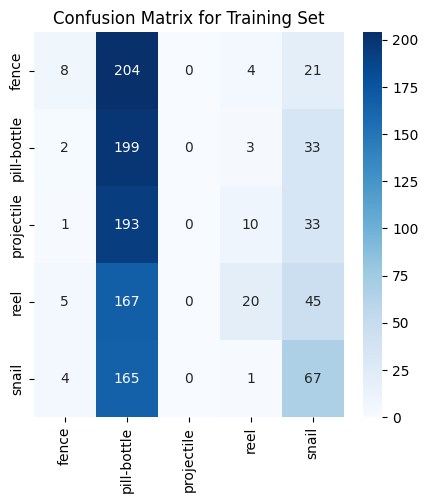

Classification Report for Training Set:
              precision    recall  f1-score   support

       fence       0.40      0.03      0.06       237
 pill-bottle       0.21      0.84      0.34       237
  projectile       0.00      0.00      0.00       237
        reel       0.53      0.08      0.15       237
       snail       0.34      0.28      0.31       237

    accuracy                           0.25      1185
   macro avg       0.30      0.25      0.17      1185
weighted avg       0.30      0.25      0.17      1185


Custom Metrics for Training Set:

Fence:
Sensitivity (Recall): 0.034
PPV (Precision): 0.400

Pill-bottle:
Sensitivity (Recall): 0.840
PPV (Precision): 0.214

Projectile:
Sensitivity (Recall): 0.000
PPV (Precision): 0.000

Reel:
Sensitivity (Recall): 0.084
PPV (Precision): 0.526

Snail:
Sensitivity (Recall): 0.283
PPV (Precision): 0.337
8/8 [==============================] - 0s 3ms/step - loss: 1.6258 - accuracy: 0.2160

Test Accuracy: 0.2160000056028366


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

8/8 [==============================] - 0s 2ms/step


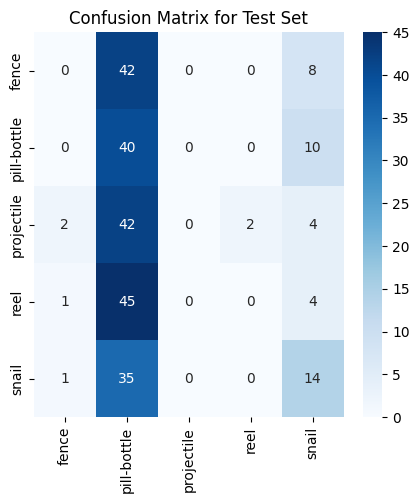

Classification Report for Test Set:
              precision    recall  f1-score   support

       fence       0.00      0.00      0.00        50
 pill-bottle       0.20      0.80      0.31        50
  projectile       0.00      0.00      0.00        50
        reel       0.00      0.00      0.00        50
       snail       0.35      0.28      0.31        50

    accuracy                           0.22       250
   macro avg       0.11      0.22      0.13       250
weighted avg       0.11      0.22      0.13       250


Custom Metrics for Test Set:

Fence:
Sensitivity (Recall): 0.000
PPV (Precision): 0.000

Pill-bottle:
Sensitivity (Recall): 0.800
PPV (Precision): 0.196

Projectile:
Sensitivity (Recall): 0.000
PPV (Precision): 0.000

Reel:
Sensitivity (Recall): 0.000
PPV (Precision): 0.000

Snail:
Sensitivity (Recall): 0.280
PPV (Precision): 0.350


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [34]:
#Balanced
def print_custom_metrics(y_true, y_pred, classes):
    for i, class_name in enumerate(classes):
        sensitivity = recall_score(y_true, y_pred, labels=[i], average='weighted')
        ppv = precision_score(y_true, y_pred, labels=[i], average='weighted')

        print(f"\n{class_name.capitalize()}:")
        print(f"Sensitivity (Recall): {sensitivity:.3f}")
        print(f"PPV (Precision): {ppv:.3f}")

model.fit(X_train_balanced_flat, y_train_balanced_encoded, validation_data=(X_val_flat, y_val_encoded), epochs=100, batch_size=64)


train_loss, train_accuracy = model.evaluate(X_train_balanced_flat, y_train_balanced_encoded)
print("Train Accuracy:", train_accuracy)


y_train_pred = model.predict(X_train_balanced_flat)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_train_true_classes = np.argmax(y_train_balanced_encoded, axis=1)

classes = ["fence", "pill-bottle", "projectile", "reel", "snail"]
train_cm = confusion_matrix(y_train_true_classes, y_train_pred_classes)
plt.figure(figsize=(5, 5))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix for Training Set')
plt.show()


print("Classification Report for Training Set:")
print(classification_report(y_train_true_classes, y_train_pred_classes, target_names=classes))


print("\nCustom Metrics for Training Set:")
print_custom_metrics(y_train_true_classes, y_train_pred_classes, classes)


test_loss, test_accuracy = model.evaluate(X_test_flat, y_test_encoded)
print("\nTest Accuracy:", test_accuracy)


y_test_pred = model.predict(X_test_flat)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true_classes = np.argmax(y_test_encoded, axis=1)

test_cm = confusion_matrix(y_test_true_classes, y_test_pred_classes)
plt.figure(figsize=(5, 5))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix for Test Set')
plt.show()

print("Classification Report for Test Set:")
print(classification_report(y_test_true_classes, y_test_pred_classes, target_names=classes))

print("\nCustom Metrics for Test Set:")
print_custom_metrics(y_test_true_classes, y_test_pred_classes, classes)

nn_balanced_metrics = {
    "Accuracy": test_accuracy * 100,
    "Precision": precision_score(y_test_true_classes, y_test_pred_classes, average='weighted') * 100,
    "Recall": recall_score(y_test_true_classes, y_test_pred_classes, average='weighted') * 100,
    "F1-Score": f1_score(y_test_true_classes, y_test_pred_classes, average='weighted') * 100
}

## AlexNet

In [35]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def alexnet_model(input_shape, num_classes):
    model = models.Sequential()

    model.add(layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))

    model.add(layers.Conv2D(256, (5, 5), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))

    model.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_97 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 27, 27, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_98 (Conv2D)          (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 13, 13, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_99 (Conv2D)          (None, 13, 13, 384)       885120    
                                                                 
 conv2d_100 (Conv2D)         (None, 13, 13, 384)      

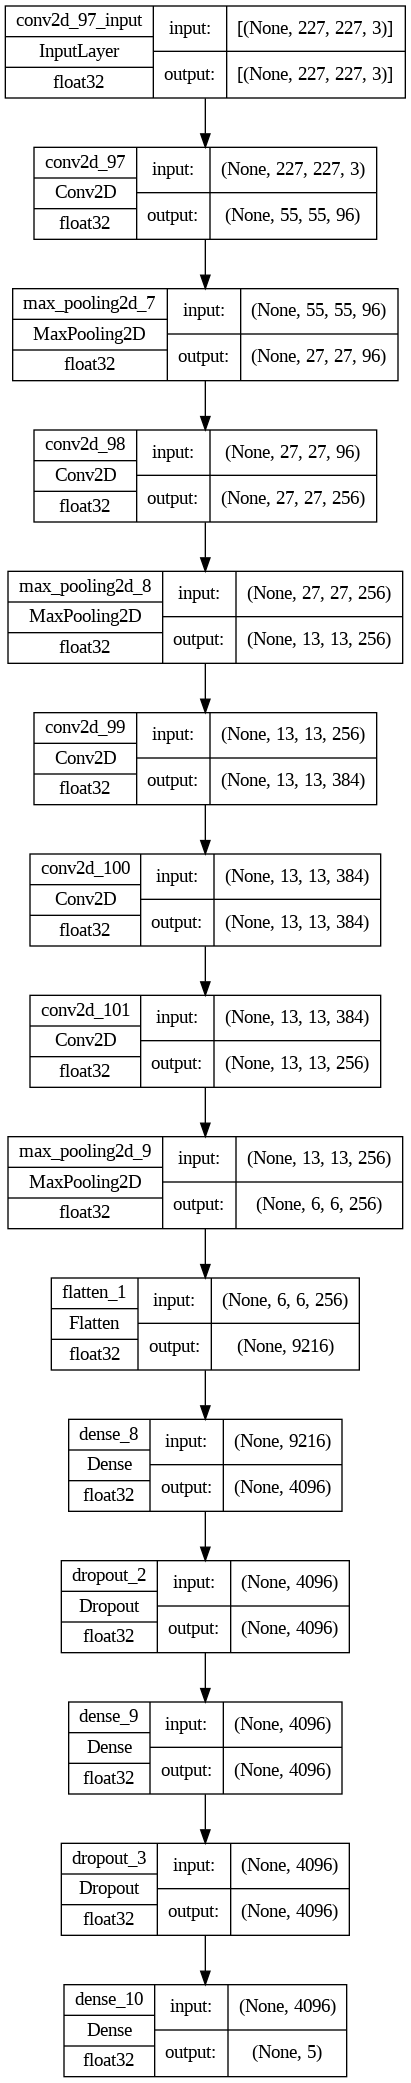

In [36]:
input_shape = (227, 227, 3)
num_classes = 5
alexnet = alexnet_model(input_shape, num_classes)

alexnet.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

alexnet.summary()
plot_model(alexnet, show_shapes=True, show_dtype=True, show_layer_names=True)

In [37]:
X_train_resized = np.array([img_to_array(array_to_img(img).resize((227, 227))) for img in X_train_balanced])
X_val_resized = np.array([img_to_array(array_to_img(img).resize((227, 227))) for img in X_val])
X_test_resized = np.array([img_to_array(array_to_img(img).resize((227, 227))) for img in X_test])

history = alexnet.fit(X_train_resized, y_train_balanced_encoded, validation_data=(X_val_resized, y_val_encoded), epochs=50, batch_size=32)

Epoch 1/50
38/38 [==============================] - 8s 89ms/step - loss: 83.9111 - accuracy: 0.2000 - val_loss: 1.6344 - val_accuracy: 0.1092
Epoch 2/50
38/38 [==============================] - 2s 54ms/step - loss: 1.6125 - accuracy: 0.1848 - val_loss: 1.6213 - val_accuracy: 0.1264
Epoch 3/50
38/38 [==============================] - 2s 59ms/step - loss: 1.6150 - accuracy: 0.1975 - val_loss: 1.6105 - val_accuracy: 0.1264
Epoch 4/50
38/38 [==============================] - 2s 59ms/step - loss: 1.6829 - accuracy: 0.2076 - val_loss: 1.6037 - val_accuracy: 0.1092
Epoch 5/50
38/38 [==============================] - 2s 54ms/step - loss: 1.6075 - accuracy: 0.2262 - val_loss: 1.6257 - val_accuracy: 0.1207
Epoch 6/50
38/38 [==============================] - 2s 53ms/step - loss: 1.6140 - accuracy: 0.1831 - val_loss: 1.6063 - val_accuracy: 0.3621
Epoch 7/50
38/38 [==============================] - 2s 54ms/step - loss: 1.6103 - accuracy: 0.1882 - val_loss: 1.6060 - val_accuracy: 0.3621
Epoch 8/50
3

In [ ]:
# model_save_path = "/content/drive/MyDrive/alexnet_model.h5"
# save_model(alexnet, model_save_path)

# model_load_path = "/content/drive/MyDrive/alexnet_model.h5"
# loaded_alexnet = load_model(model_load_path)

<ipython-input-23-3d00109489ea>:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(alexnet, model_save_path)


64/64 [==============================] - 1s 22ms/step - loss: 1.6096 - accuracy: 0.2000

Training Accuracy: 0.20000000298023224
64/64 [==============================] - 2s 21ms/step


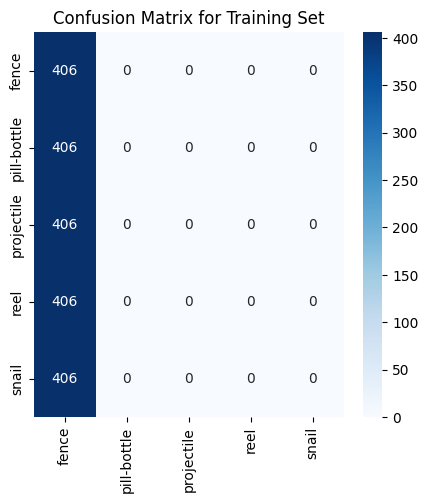

Classification Report for Training Set:
              precision    recall  f1-score   support

       fence       0.20      1.00      0.33       406
 pill-bottle       0.00      0.00      0.00       406
  projectile       0.00      0.00      0.00       406
        reel       0.00      0.00      0.00       406
       snail       0.00      0.00      0.00       406

    accuracy                           0.20      2030
   macro avg       0.04      0.20      0.07      2030
weighted avg       0.04      0.20      0.07      2030


Custom Metrics for Training Set:

Fence:
Sensitivity (Recall): 1.000
PPV (Precision): 0.200

Pill-bottle:
Sensitivity (Recall): 0.000
PPV (Precision): 0.000

Projectile:
Sensitivity (Recall): 0.000
PPV (Precision): 0.000

Reel:
Sensitivity (Recall): 0.000
PPV (Precision): 0.000

Snail:
Sensitivity (Recall): 0.000
PPV (Precision): 0.000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

8/8 [==============================] - 0s 17ms/step - loss: 1.6096 - accuracy: 0.2000

Test Accuracy: 0.20000000298023224
8/8 [==============================] - 0s 17ms/step


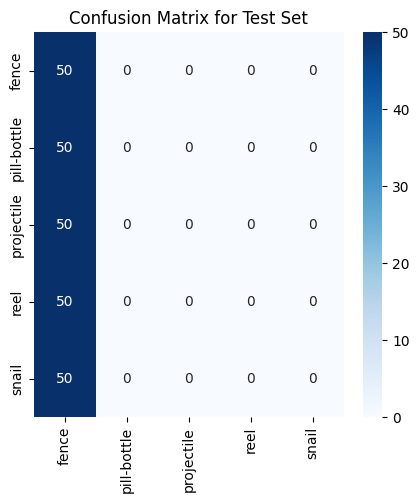

Classification Report for Test Set:
              precision    recall  f1-score   support

       fence       0.20      1.00      0.33        50
 pill-bottle       0.00      0.00      0.00        50
  projectile       0.00      0.00      0.00        50
        reel       0.00      0.00      0.00        50
       snail       0.00      0.00      0.00        50

    accuracy                           0.20       250
   macro avg       0.04      0.20      0.07       250
weighted avg       0.04      0.20      0.07       250


Custom Metrics for Test Set:

Fence:
Sensitivity (Recall): 1.000
PPV (Precision): 0.200

Pill-bottle:
Sensitivity (Recall): 0.000
PPV (Precision): 0.000

Projectile:
Sensitivity (Recall): 0.000
PPV (Precision): 0.000

Reel:
Sensitivity (Recall): 0.000
PPV (Precision): 0.000

Snail:
Sensitivity (Recall): 0.000
PPV (Precision): 0.000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [78]:
# Assuming you have trained your AlexNet model and obtained predictions for both training and test sets

# Calculate training accuracy
X_train_resized = np.array([img_to_array(array_to_img(img).resize((227, 227))) for img in X_train_balanced])
X_val_resized = np.array([img_to_array(array_to_img(img).resize((227, 227))) for img in X_val])
X_test_resized = np.array([img_to_array(array_to_img(img).resize((227, 227))) for img in X_test])
train_loss, train_accuracy = alexnet.evaluate(X_train_resized, y_train_balanced_encoded)
print("\nTraining Accuracy:", train_accuracy)

# Confusion matrix and metrics for training set
y_train_pred = alexnet.predict(X_train_resized)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_train_true_classes = np.argmax(y_train_balanced_encoded, axis=1)

train_cm = confusion_matrix(y_train_true_classes, y_train_pred_classes)
plt.figure(figsize=(5, 5))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix for Training Set')
plt.show()

print("Classification Report for Training Set:")
print(classification_report(y_train_true_classes, y_train_pred_classes, target_names=classes))

print("\nCustom Metrics for Training Set:")
print_custom_metrics(y_train_true_classes, y_train_pred_classes, classes)

# Evaluate and print test set metrics
test_loss, test_accuracy = alexnet.evaluate(X_test_resized, y_test_encoded)
print("\nTest Accuracy:", test_accuracy)

y_test_pred = alexnet.predict(X_test_resized)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true_classes = np.argmax(y_test_encoded, axis=1)

test_cm = confusion_matrix(y_test_true_classes, y_test_pred_classes)
plt.figure(figsize=(5, 5))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix for Test Set')
plt.show()

print("Classification Report for Test Set:")
print(classification_report(y_test_true_classes, y_test_pred_classes, target_names=classes))

print("\nCustom Metrics for Test Set:")
print_custom_metrics(y_test_true_classes, y_test_pred_classes, classes)

# Store metrics in a dictionary for later reference
alexnet_metrics = {
    "Training Accuracy": train_accuracy * 100,
    "Test Accuracy": test_accuracy * 100,
    "Precision": precision_score(y_test_true_classes, y_test_pred_classes, average='weighted') * 100,
    "Recall": recall_score(y_test_true_classes, y_test_pred_classes, average='weighted') * 100,
    "F1-Score": f1_score(y_test_true_classes, y_test_pred_classes, average='weighted') * 100
}

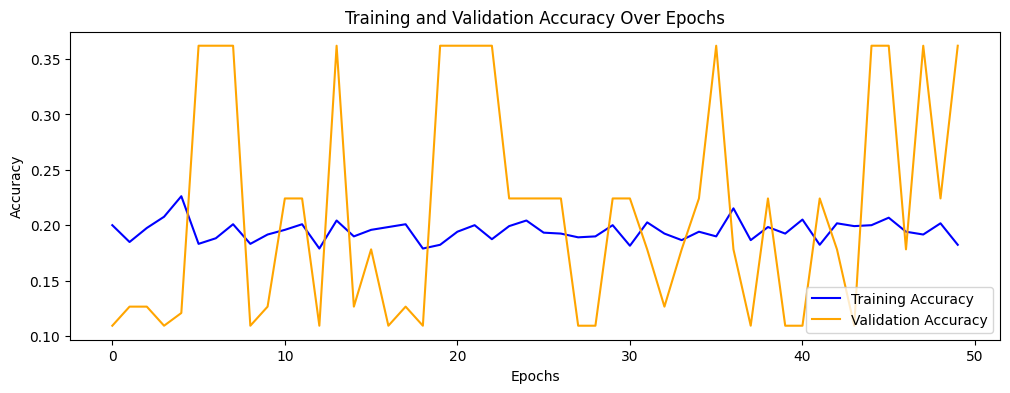

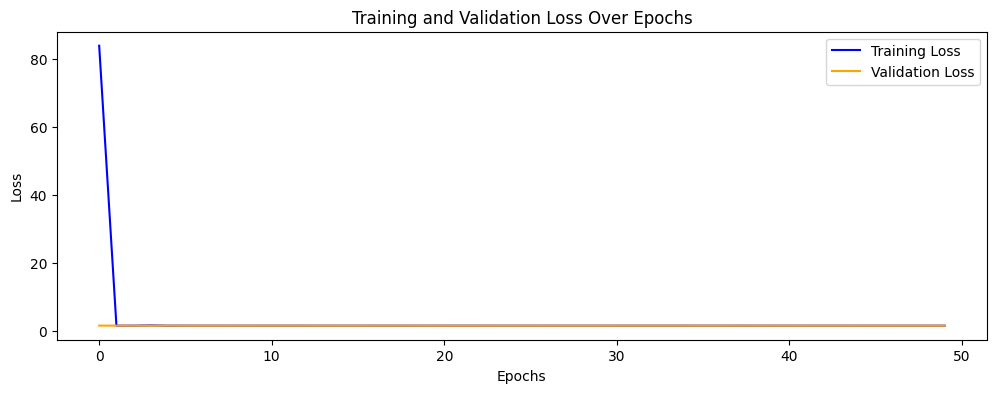

In [39]:
plt.figure(figsize=(12, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

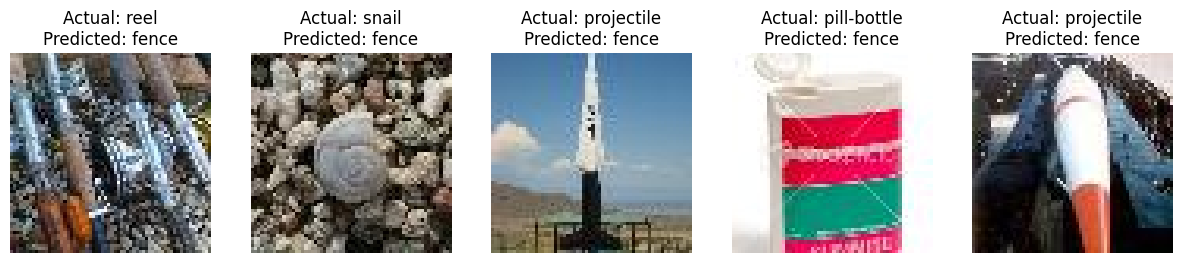

In [40]:
misclassified_indices = np.where(y_test_true_classes != y_test_pred_classes)[0]

random_misclassified_indices = np.random.choice(misclassified_indices, 5, replace=False)

plt.figure(figsize=(15, 5))
for i, index in enumerate(random_misclassified_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_test[index])
    plt.title(f"Actual: {classes[y_test_true_classes[index]]}\nPredicted: {classes[y_test_pred_classes[index]]}")
    plt.axis('off')

plt.show()

## ResNet-34

In [42]:
import tensorflow as tf
from tensorflow.keras.layers import Input, ZeroPadding2D, Conv2D, BatchNormalization, Activation, MaxPooling2D, AveragePooling2D, Add, Flatten, Dense
from tensorflow.keras.models import Model

def resnet_identity_block(x, filters, kernel_size):
    f1, f2, f3 = filters
    x_shortcut = x

    x = Conv2D(f1, (1, 1), padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f2, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f3, (1, 1), padding='valid')(x)
    x = BatchNormalization()(x)

    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)

    return x

def resnet_convolutional_block(x, filters, kernel_size, strides):
    f1, f2, f3 = filters
    x_shortcut = x


    x = Conv2D(f1, (1, 1), strides=strides)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    x = Conv2D(f2, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    x = Conv2D(f3, (1, 1), padding='valid')(x)
    x = BatchNormalization()(x)


    x_shortcut = Conv2D(f3, (1, 1), strides=strides)(x_shortcut)
    x_shortcut = BatchNormalization()(x_shortcut)


    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)

    return x

def ResNet34(input_shape=(224, 224, 3), classes=1000):

    x_input = Input(input_shape)

    x = ZeroPadding2D((3, 3))(x_input)

    x = Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = resnet_convolutional_block(x, filters=[64, 64, 256], kernel_size=(3, 3), strides=(1, 1))
    x = resnet_identity_block(x, [64, 64, 256], (3, 3))
    x = resnet_identity_block(x, [64, 64, 256], (3, 3))

    x = resnet_convolutional_block(x, filters=[128, 128, 512], kernel_size=(3, 3), strides=(2, 2))
    x = resnet_identity_block(x, [128, 128, 512], (3, 3))
    x = resnet_identity_block(x, [128, 128, 512], (3, 3))
    x = resnet_identity_block(x, [128, 128, 512], (3, 3))

    x = resnet_convolutional_block(x, filters=[256, 256, 1024], kernel_size=(3, 3), strides=(2, 2))
    x = resnet_identity_block(x, [256, 256, 1024], (3, 3))
    x = resnet_identity_block(x, [256, 256, 1024], (3, 3))
    x = resnet_identity_block(x, [256, 256, 1024], (3, 3))
    x = resnet_identity_block(x, [256, 256, 1024], (3, 3))
    x = resnet_identity_block(x, [256, 256, 1024], (3, 3))


    x = resnet_convolutional_block(x, filters=[512, 512, 2048], kernel_size=(3, 3), strides=(2, 2))
    x = resnet_identity_block(x, [512, 512, 2048], (3, 3))
    x = resnet_identity_block(x, [512, 512, 2048], (3, 3))

    x = AveragePooling2D(pool_size=(2, 2), padding='same')(x)


    x = Flatten()(x)
    x = Dense(classes, activation='softmax')(x)

    model = Model(inputs=x_input, outputs=x, name='ResNet34')

    return model

In [43]:
resnet34 = ResNet34(input_shape=(224, 224, 3), classes=5)
resnet34.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

resnet34.summary()

plot_model(resnet34, show_shapes=True, show_dtype=True, show_layer_names=True)

Output hidden; open in https://colab.research.google.com to view.

In [44]:
X_train_resized_res = np.array([img_to_array(array_to_img(img).resize((224, 224))) for img in X_train_balanced])
X_val_resized_res = np.array([img_to_array(array_to_img(img).resize((224, 224))) for img in X_val])
X_test_resized_res = np.array([img_to_array(array_to_img(img).resize((224, 224))) for img in X_test])

history_resnet = resnet34.fit(X_train_resized_res, y_train_balanced_encoded,
                                             validation_data=(X_val_resized_res, y_val_encoded),
                                             epochs=50,
                                             batch_size=32)

Epoch 1/50
38/38 [==============================] - 60s 456ms/step - loss: 7.7597 - accuracy: 0.2135 - val_loss: 125931.7031 - val_accuracy: 0.1379
Epoch 2/50
38/38 [==============================] - 13s 330ms/step - loss: 5.1773 - accuracy: 0.2177 - val_loss: 1.6152 - val_accuracy: 0.2126
Epoch 3/50
38/38 [==============================] - 13s 333ms/step - loss: 2.6063 - accuracy: 0.3004 - val_loss: 2.3174 - val_accuracy: 0.1667
Epoch 4/50
38/38 [==============================] - 13s 337ms/step - loss: 2.7685 - accuracy: 0.2616 - val_loss: 2.3697 - val_accuracy: 0.1207
Epoch 5/50
38/38 [==============================] - 13s 337ms/step - loss: 3.0457 - accuracy: 0.2405 - val_loss: 31.1101 - val_accuracy: 0.1092
Epoch 6/50
38/38 [==============================] - 13s 338ms/step - loss: 2.6292 - accuracy: 0.2633 - val_loss: 26.0954 - val_accuracy: 0.3391
Epoch 7/50
38/38 [==============================] - 13s 337ms/step - loss: 3.2491 - accuracy: 0.2456 - val_loss: 4199.1851 - val_accura

In [ ]:
# resnet34_save_path = "/content/drive/MyDrive/resnet34_model.h5"
# save_model(resnet34, resnet34_save_path)

<ipython-input-32-b406f959b7fb>:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(resnet34, resnet34_save_path)


38/38 [==============================] - 4s 94ms/step - loss: 2.1251 - accuracy: 0.3958

Training Accuracy (ResNet-34): 0.3957805931568146
38/38 [==============================] - 4s 92ms/step


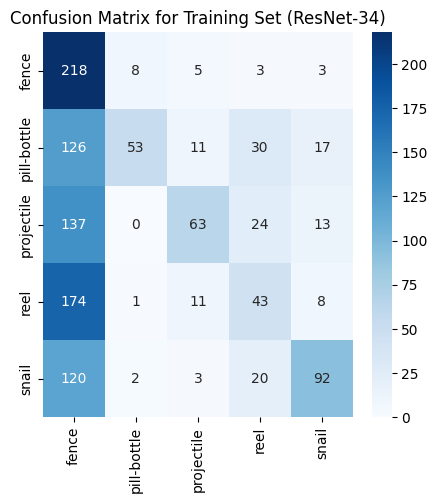

Classification Report for Training Set (ResNet-34):
              precision    recall  f1-score   support

       fence       0.28      0.92      0.43       237
 pill-bottle       0.83      0.22      0.35       237
  projectile       0.68      0.27      0.38       237
        reel       0.36      0.18      0.24       237
       snail       0.69      0.39      0.50       237

    accuracy                           0.40      1185
   macro avg       0.57      0.40      0.38      1185
weighted avg       0.57      0.40      0.38      1185


Custom Metrics for Training Set (ResNet-34):

Fence:
Sensitivity (Recall): 0.920
PPV (Precision): 0.281

Pill-bottle:
Sensitivity (Recall): 0.224
PPV (Precision): 0.828

Projectile:
Sensitivity (Recall): 0.266
PPV (Precision): 0.677

Reel:
Sensitivity (Recall): 0.181
PPV (Precision): 0.358

Snail:
Sensitivity (Recall): 0.388
PPV (Precision): 0.692
8/8 [==============================] - 3s 366ms/step - loss: 2.6901 - accuracy: 0.3120

Test Accuracy (ResNe

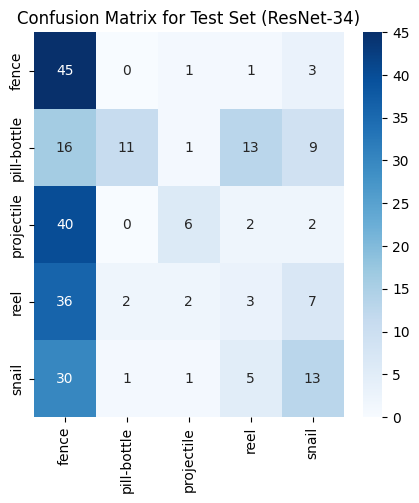

Classification Report for Test Set (ResNet-34):
              precision    recall  f1-score   support

       fence       0.27      0.90      0.41        50
 pill-bottle       0.79      0.22      0.34        50
  projectile       0.55      0.12      0.20        50
        reel       0.12      0.06      0.08        50
       snail       0.38      0.26      0.31        50

    accuracy                           0.31       250
   macro avg       0.42      0.31      0.27       250
weighted avg       0.42      0.31      0.27       250


Custom Metrics for Test Set (ResNet-34):

Fence:
Sensitivity (Recall): 0.900
PPV (Precision): 0.269

Pill-bottle:
Sensitivity (Recall): 0.220
PPV (Precision): 0.786

Projectile:
Sensitivity (Recall): 0.120
PPV (Precision): 0.545

Reel:
Sensitivity (Recall): 0.060
PPV (Precision): 0.125

Snail:
Sensitivity (Recall): 0.260
PPV (Precision): 0.382


In [45]:
# Training metrics
train_loss_resnet, train_accuracy_resnet = resnet34.evaluate(X_train_resized_res, y_train_balanced_encoded)
print("\nTraining Accuracy (ResNet-34):", train_accuracy_resnet)

y_train_pred_resnet = resnet34.predict(X_train_resized_res)
y_train_pred_classes_resnet = np.argmax(y_train_pred_resnet, axis=1)
y_train_true_classes_resnet = np.argmax(y_train_balanced_encoded, axis=1)

train_cm_resnet = confusion_matrix(y_train_true_classes_resnet, y_train_pred_classes_resnet)
plt.figure(figsize=(5, 5))
sns.heatmap(train_cm_resnet, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix for Training Set (ResNet-34)')
plt.show()

print("Classification Report for Training Set (ResNet-34):")
print(classification_report(y_train_true_classes_resnet, y_train_pred_classes_resnet, target_names=classes))

print("\nCustom Metrics for Training Set (ResNet-34):")
print_custom_metrics(y_train_true_classes_resnet, y_train_pred_classes_resnet, classes)

# Test metrics for ResNet-34
test_loss_resnet, test_accuracy_resnet = resnet34.evaluate(X_test_resized_res, y_test_encoded)
print("\nTest Accuracy (ResNet-34):", test_accuracy_resnet)

y_test_pred_resnet = resnet34.predict(X_test_resized_res)
y_test_pred_classes_resnet = np.argmax(y_test_pred_resnet, axis=1)
y_test_true_classes_resnet = np.argmax(y_test_encoded, axis=1)

test_cm_resnet = confusion_matrix(y_test_true_classes_resnet, y_test_pred_classes_resnet)
plt.figure(figsize=(5, 5))
sns.heatmap(test_cm_resnet, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix for Test Set (ResNet-34)')
plt.show()

print("Classification Report for Test Set (ResNet-34):")
print(classification_report(y_test_true_classes_resnet, y_test_pred_classes_resnet, target_names=classes))

print("\nCustom Metrics for Test Set (ResNet-34):")
print_custom_metrics(y_test_true_classes_resnet, y_test_pred_classes_resnet, classes)

# Metrics dictionary for Test Set (ResNet-34)
resnet34_metrics = {
    "Training Accuracy": train_accuracy_resnet * 100,
    "Test Accuracy": test_accuracy_resnet * 100,
    "Precision": precision_score(y_test_true_classes_resnet, y_test_pred_classes_resnet, average='weighted') * 100,
    "Recall": recall_score(y_test_true_classes_resnet, y_test_pred_classes_resnet, average='weighted') * 100,
    "F1-Score": f1_score(y_test_true_classes_resnet, y_test_pred_classes_resnet, average='weighted') * 100
}

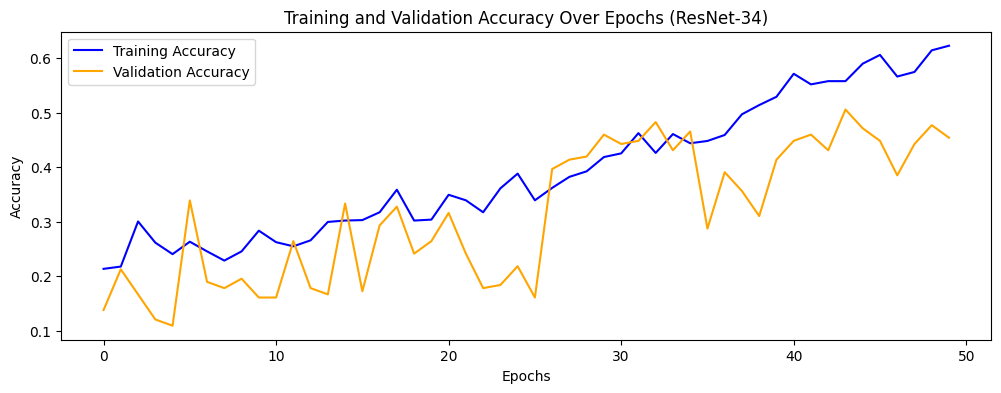

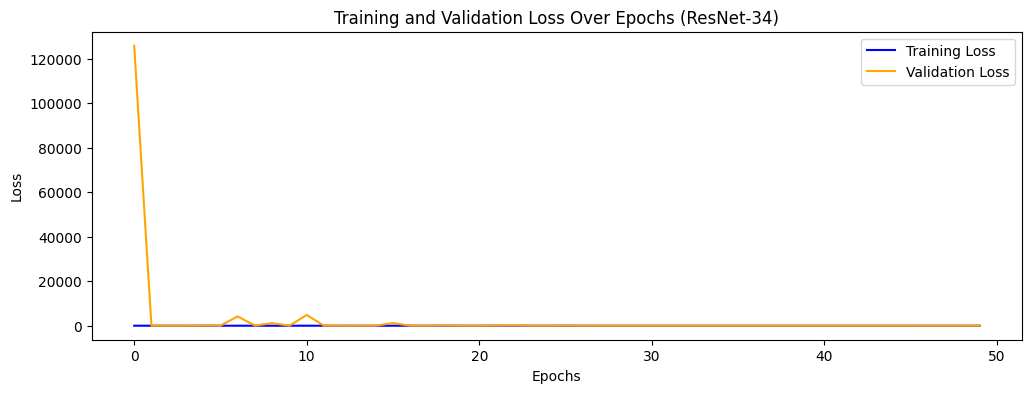

In [46]:
plt.figure(figsize=(12, 4))
plt.plot(history_resnet.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy Over Epochs (ResNet-34)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(history_resnet.history['loss'], label='Training Loss', color='blue')
plt.plot(history_resnet.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss Over Epochs (ResNet-34)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

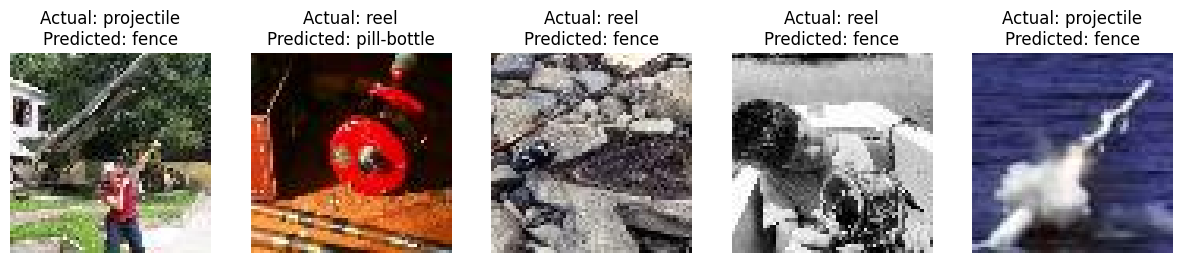

In [47]:
misclassified_indices_resnet = np.where(y_test_true_classes_resnet != y_test_pred_classes_resnet)[0]

random_misclassified_indices_resnet = np.random.choice(misclassified_indices_resnet, 5, replace=False)

plt.figure(figsize=(15, 5))
for i, index in enumerate(random_misclassified_indices_resnet):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_test[index])
    plt.title(f"Actual: {classes[y_test_true_classes_resnet[index]]}\nPredicted: {classes[y_test_pred_classes_resnet[index]]}")
    plt.axis('off')

plt.show()

## Inception Net

In [15]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

for layer in inception_model.layers:
    layer.trainable = False

X_train_resized = np.array([img_to_array(array_to_img(img).resize((299, 299))) for img in X_train_balanced])
X_val_resized = np.array([img_to_array(array_to_img(img).resize((299, 299))) for img in X_val])
X_test_resized = np.array([img_to_array(array_to_img(img).resize((299, 299))) for img in X_test])

X_train_resized = preprocess_input(X_train_resized)
X_val_resized = preprocess_input(X_val_resized)
X_test_resized = preprocess_input(X_test_resized)


def create_inception_model(input_shape, num_classes):
    model = models.Sequential()
    model.add(inception_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(1000, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

input_shape_inception = (299, 299, 3)
num_classes_inception = 5
inception_model_instance = create_inception_model(input_shape_inception, num_classes_inception)

In [ ]:
inception_model_instance.summary()
plot_model(inception_model_instance, show_shapes=True, show_dtype=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1000)              2049000   
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 5)                 5005      
                                                                 


In [ ]:
inception_model_instance.compile(optimizer=optimizers.Adam(),
                                 loss='categorical_crossentropy',
                                 metrics=['accuracy'])

history_inception = inception_model_instance.fit(X_train_resized, y_train_balanced_encoded,
                                                 validation_data=(X_val_resized, y_val_encoded),
                                                 epochs=50,
                                                 batch_size=32)

Epoch 1/50
65/65 [==============================] - 32s 283ms/step - loss: 0.5885 - accuracy: 0.8112 - val_loss: 0.2843 - val_accuracy: 0.9023
Epoch 2/50
65/65 [==============================] - 10s 161ms/step - loss: 0.2365 - accuracy: 0.9212 - val_loss: 0.1935 - val_accuracy: 0.9326
Epoch 3/50
65/65 [==============================] - 10s 151ms/step - loss: 0.1551 - accuracy: 0.9489 - val_loss: 0.1730 - val_accuracy: 0.9419
Epoch 4/50
65/65 [==============================] - 10s 152ms/step - loss: 0.1680 - accuracy: 0.9421 - val_loss: 0.1672 - val_accuracy: 0.9442
Epoch 5/50
65/65 [==============================] - 11s 163ms/step - loss: 0.1229 - accuracy: 0.9562 - val_loss: 0.1847 - val_accuracy: 0.9372
Epoch 6/50
65/65 [==============================] - 10s 147ms/step - loss: 0.1538 - accuracy: 0.9431 - val_loss: 0.1732 - val_accuracy: 0.9395
Epoch 7/50
65/65 [==============================] - 11s 166ms/step - loss: 0.1039 - accuracy: 0.9640 - val_loss: 0.1821 - val_accuracy: 0.9442

In [18]:
# inception_save_path = "/content/drive/MyDrive/inception_model.h5"
# save_model(inception_model_instance, inception_save_path)

<ipython-input-18-d4146b5edaee>:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(inception_model_instance, inception_save_path)


In [ ]:
# Training metrics for InceptionV3
train_loss_inception, train_accuracy_inception = inception_model_instance.evaluate(X_train_resized, y_train_balanced_encoded)
print("\nTraining Accuracy (InceptionV3):", train_accuracy_inception)

y_train_pred_inception = inception_model_instance.predict(X_train_resized)
y_train_pred_classes_inception = np.argmax(y_train_pred_inception, axis=1)
y_train_true_classes_inception = np.argmax(y_train_balanced_encoded, axis=1)

train_cm_inception = confusion_matrix(y_train_true_classes_inception, y_train_pred_classes_inception)
plt.figure(figsize=(5, 5))
sns.heatmap(train_cm_inception, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix for Training Set (InceptionV3)')
plt.show()

print("Classification Report for Training Set (InceptionV3):")
print(classification_report(y_train_true_classes_inception, y_train_pred_classes_inception, target_names=classes))

print("\nCustom Metrics for Training Set (InceptionV3):")
print_custom_metrics(y_train_true_classes_inception, y_train_pred_classes_inception, classes)

# Testing metrics for InceptionV3
test_loss_inception, test_accuracy_inception = inception_model_instance.evaluate(X_test_resized, y_test_encoded)
print("\nTest Accuracy (InceptionV3):", test_accuracy_inception)

y_test_pred_inception = inception_model_instance.predict(X_test_resized)
y_test_pred_classes_inception = np.argmax(y_test_pred_inception, axis=1)
y_test_true_classes_inception = np.argmax(y_test_encoded, axis=1)

test_cm_inception = confusion_matrix(y_test_true_classes_inception, y_test_pred_classes_inception)
plt.figure(figsize=(5, 5))
sns.heatmap(test_cm_inception, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix for Test Set (InceptionV3)')
plt.show()

print("Classification Report for Test Set (InceptionV3):")
print(classification_report(y_test_true_classes_inception, y_test_pred_classes_inception, target_names=classes))

print("\nCustom Metrics for Test Set (InceptionV3):")
print_custom_metrics(y_test_true_classes_inception, y_test_pred_classes_inception, classes)

# Store metrics in a dictionary for later reference
inception_metrics = {
    "Training Accuracy": train_accuracy_inception * 100,
    "Test Accuracy": test_accuracy_inception * 100,
    "Precision": precision_score(y_test_true_classes_inception, y_test_pred_classes_inception, average='weighted') * 100,
    "Recall": recall_score(y_test_true_classes_inception, y_test_pred_classes_inception, average='weighted') * 100,
    "F1-Score": f1_score(y_test_true_classes_inception, y_test_pred_classes_inception, average='weighted') * 100
}

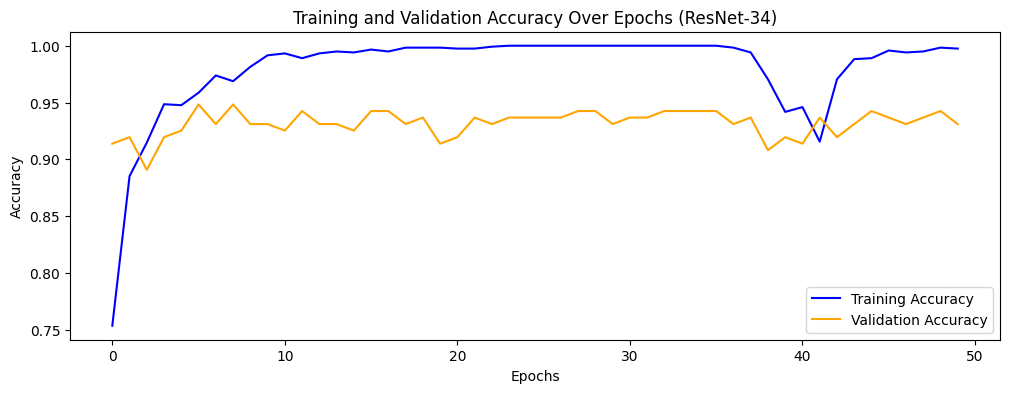

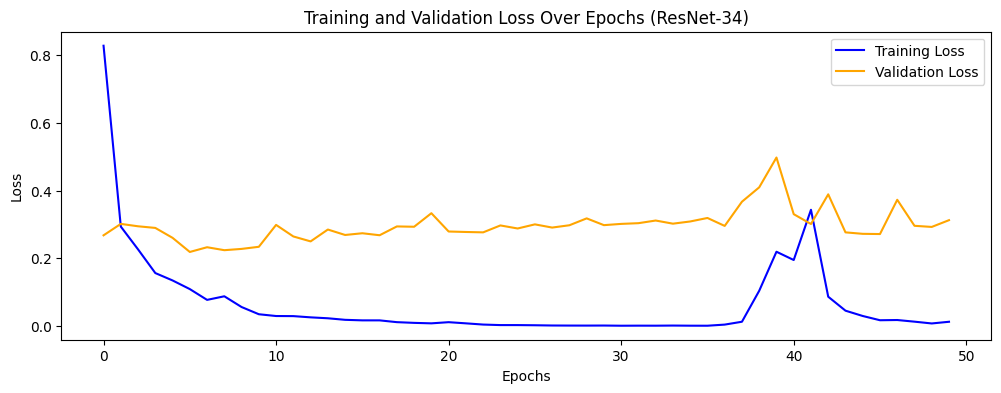

In [20]:
plt.figure(figsize=(12, 4))
plt.plot(history_inception.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history_inception.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy Over Epochs (ResNet-34)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(history_inception.history['loss'], label='Training Loss', color='blue')
plt.plot(history_inception.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss Over Epochs (ResNet-34)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

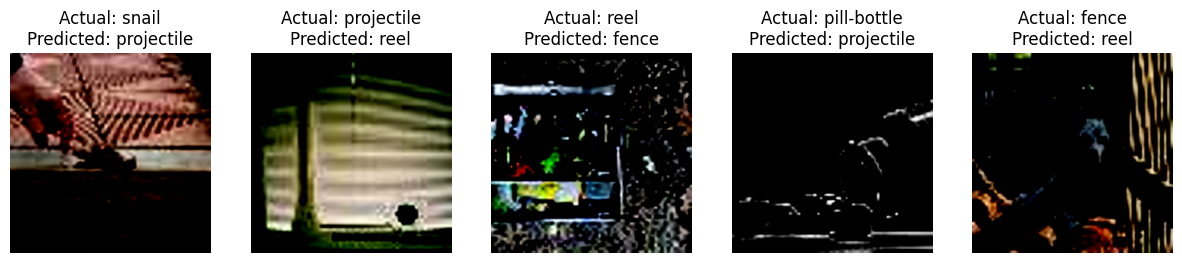

In [21]:
misclassified_indices_inception = np.where(y_test_true_classes_inception != y_test_pred_classes_inception)[0]

random_misclassified_indices_inception = np.random.choice(misclassified_indices_inception, 5, replace=False)

plt.figure(figsize=(15, 5))
for i, index in enumerate(random_misclassified_indices_inception):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_test_resized[index])
    plt.title(f"Actual: {classes[y_test_true_classes_inception[index]]}\nPredicted: {classes[y_test_pred_classes_inception[index]]}")
    plt.axis('off')

plt.show()

## Custom Model




In [68]:
def create_simple_cnn_model(input_shape, num_classes):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_155 (Conv2D)         (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 31, 31, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_156 (Conv2D)         (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_157 (Conv2D)         (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 6, 6, 128)        

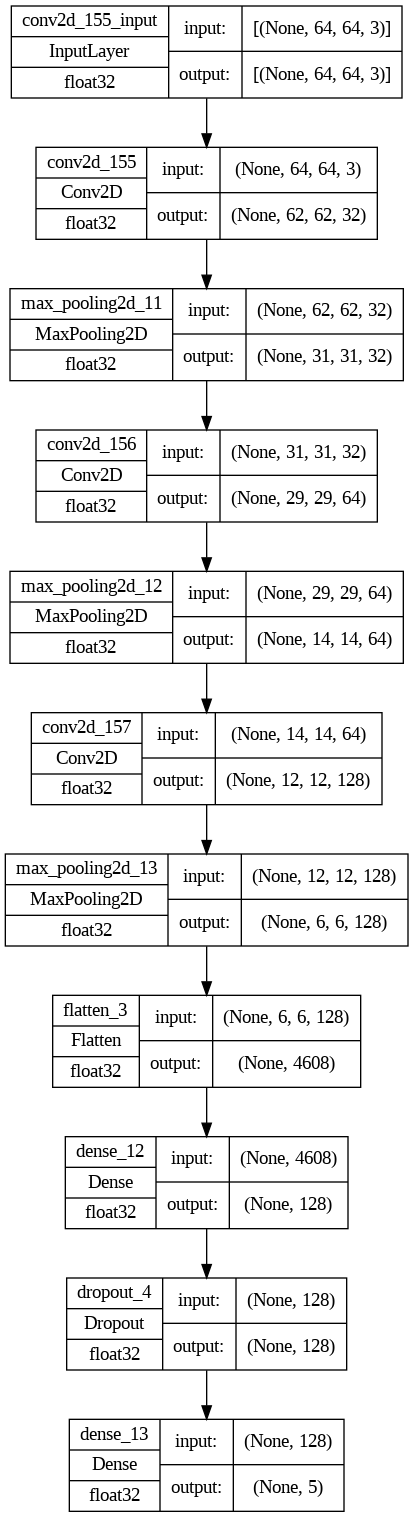

In [69]:
input_shape_simple_cnn = (64, 64, 3)
num_classes_simple_cnn = 5


simple_cnn_model = create_simple_cnn_model(input_shape_simple_cnn, num_classes_simple_cnn)

simple_cnn_model.compile(optimizer='adam',
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

simple_cnn_model.summary()
plot_model(simple_cnn_model, show_shapes=True, show_dtype=True, show_layer_names=True)

In [70]:
# Train the model
history_custom_cnn = simple_cnn_model.fit(X_train_balanced, y_train_balanced_encoded,
                                          validation_data=(X_val, y_val_encoded),
                                          epochs=50,
                                          batch_size=32)

Epoch 1/50
64/64 [==============================] - 3s 21ms/step - loss: 2.2879 - accuracy: 0.2990 - val_loss: 1.5856 - val_accuracy: 0.3465
Epoch 2/50
64/64 [==============================] - 0s 7ms/step - loss: 1.3968 - accuracy: 0.4030 - val_loss: 1.4243 - val_accuracy: 0.4442
Epoch 3/50
64/64 [==============================] - 0s 7ms/step - loss: 1.3931 - accuracy: 0.4768 - val_loss: 1.3590 - val_accuracy: 0.4791
Epoch 4/50
64/64 [==============================] - 0s 8ms/step - loss: 1.2315 - accuracy: 0.5197 - val_loss: 1.2941 - val_accuracy: 0.5209
Epoch 5/50
64/64 [==============================] - 0s 7ms/step - loss: 1.1551 - accuracy: 0.5581 - val_loss: 1.2861 - val_accuracy: 0.4605
Epoch 6/50
64/64 [==============================] - 0s 7ms/step - loss: 1.1373 - accuracy: 0.5621 - val_loss: 1.1976 - val_accuracy: 0.5256
Epoch 7/50
64/64 [==============================] - 0s 7ms/step - loss: 1.0595 - accuracy: 0.5921 - val_loss: 1.1448 - val_accuracy: 0.5698
Epoch 8/50
64/64 [=

In [71]:
custom_save_path = "/content/drive/MyDrive/custom_model.h5"
save_model(simple_cnn_model, custom_save_path)

<ipython-input-71-28d380a20905>:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(simple_cnn_model, custom_save_path)


64/64 [==============================] - 0s 4ms/step - loss: 0.0380 - accuracy: 0.9877

Training Accuracy (Custom CNN): 0.9876847267150879
64/64 [==============================] - 0s 3ms/step


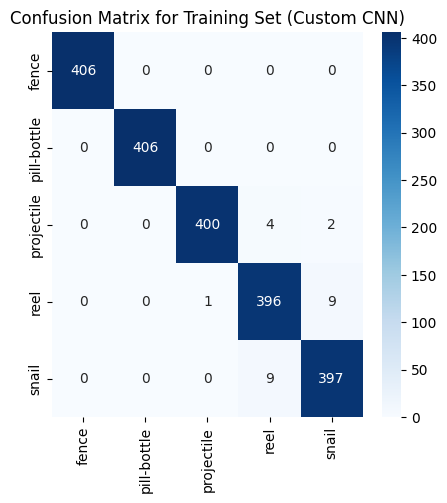

Classification Report for Training Set (Custom CNN):
              precision    recall  f1-score   support

       fence       1.00      1.00      1.00       406
 pill-bottle       1.00      1.00      1.00       406
  projectile       1.00      0.99      0.99       406
        reel       0.97      0.98      0.97       406
       snail       0.97      0.98      0.98       406

    accuracy                           0.99      2030
   macro avg       0.99      0.99      0.99      2030
weighted avg       0.99      0.99      0.99      2030

8/8 [==============================] - 0s 4ms/step - loss: 2.1323 - accuracy: 0.5960

Test Accuracy (Custom CNN): 0.5960000157356262
8/8 [==============================] - 0s 3ms/step


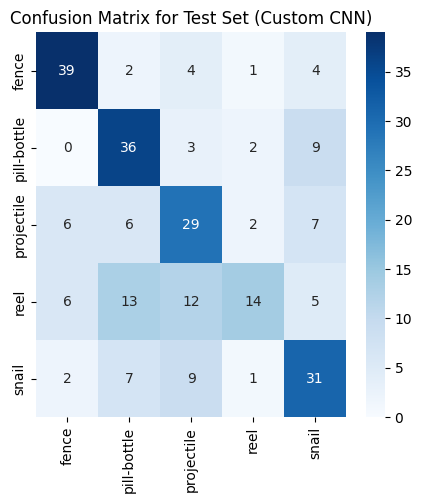

Classification Report for Test Set (Custom CNN):
              precision    recall  f1-score   support

       fence       0.74      0.78      0.76        50
 pill-bottle       0.56      0.72      0.63        50
  projectile       0.51      0.58      0.54        50
        reel       0.70      0.28      0.40        50
       snail       0.55      0.62      0.58        50

    accuracy                           0.60       250
   macro avg       0.61      0.60      0.58       250
weighted avg       0.61      0.60      0.58       250



In [72]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Evaluate the model on the training set
train_loss_custom_cnn, train_accuracy_custom_cnn = simple_cnn_model.evaluate(X_train_balanced, y_train_balanced_encoded)
print("\nTraining Accuracy (Custom CNN):", train_accuracy_custom_cnn)

# Predict on the training set
y_train_pred_custom_cnn = simple_cnn_model.predict(X_train_balanced)
y_train_pred_classes_custom_cnn = np.argmax(y_train_pred_custom_cnn, axis=1)
y_train_true_classes_custom_cnn = np.argmax(y_train_balanced_encoded, axis=1)

# Confusion Matrix for Training Set
train_cm_custom_cnn = confusion_matrix(y_train_true_classes_custom_cnn, y_train_pred_classes_custom_cnn)
plt.figure(figsize=(5, 5))
sns.heatmap(train_cm_custom_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix for Training Set (Custom CNN)')
plt.show()

# Classification Report for Training Set
print("Classification Report for Training Set (Custom CNN):")
print(classification_report(y_train_true_classes_custom_cnn, y_train_pred_classes_custom_cnn, target_names=classes))

# Evaluate the model on the test set
test_loss_custom_cnn, test_accuracy_custom_cnn = simple_cnn_model.evaluate(X_test, y_test_encoded)
print("\nTest Accuracy (Custom CNN):", test_accuracy_custom_cnn)

# Predict on the test set
y_test_pred_custom_cnn = simple_cnn_model.predict(X_test)
y_test_pred_classes_custom_cnn = np.argmax(y_test_pred_custom_cnn, axis=1)
y_test_true_classes_custom_cnn = np.argmax(y_test_encoded, axis=1)

# Confusion Matrix for Test Set
test_cm_custom_cnn = confusion_matrix(y_test_true_classes_custom_cnn, y_test_pred_classes_custom_cnn)
plt.figure(figsize=(5, 5))
sns.heatmap(test_cm_custom_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix for Test Set (Custom CNN)')
plt.show()

# Classification Report for Test Set
print("Classification Report for Test Set (Custom CNN):")
print(classification_report(y_test_true_classes_custom_cnn, y_test_pred_classes_custom_cnn, target_names=classes))

# Store metrics in a dictionary for later reference
custom_cnn_metrics = {
    "Training Accuracy": train_accuracy_custom_cnn * 100,
    "Test Accuracy": test_accuracy_custom_cnn * 100,
    "Precision": precision_score(y_test_true_classes_custom_cnn, y_test_pred_classes_custom_cnn, average='weighted') * 100,
    "Recall": recall_score(y_test_true_classes_custom_cnn, y_test_pred_classes_custom_cnn, average='weighted') * 100,
    "F1-Score": f1_score(y_test_true_classes_custom_cnn, y_test_pred_classes_custom_cnn, average='weighted') * 100
}

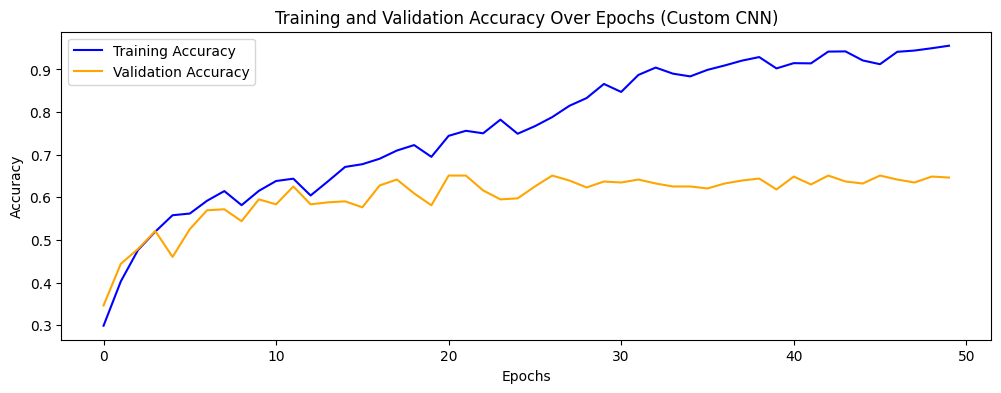

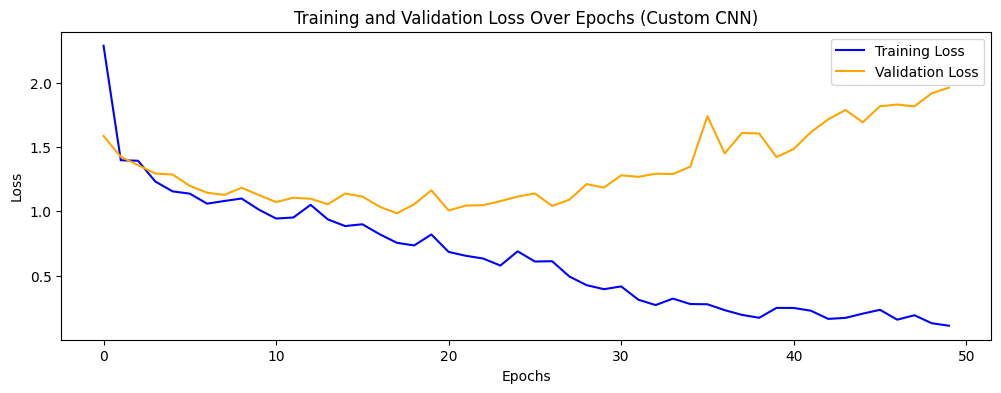

In [73]:
plt.figure(figsize=(12, 4))
plt.plot(history_custom_cnn.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history_custom_cnn.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy Over Epochs (Custom CNN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


plt.figure(figsize=(12, 4))
plt.plot(history_custom_cnn.history['loss'], label='Training Loss', color='blue')
plt.plot(history_custom_cnn.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss Over Epochs (Custom CNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

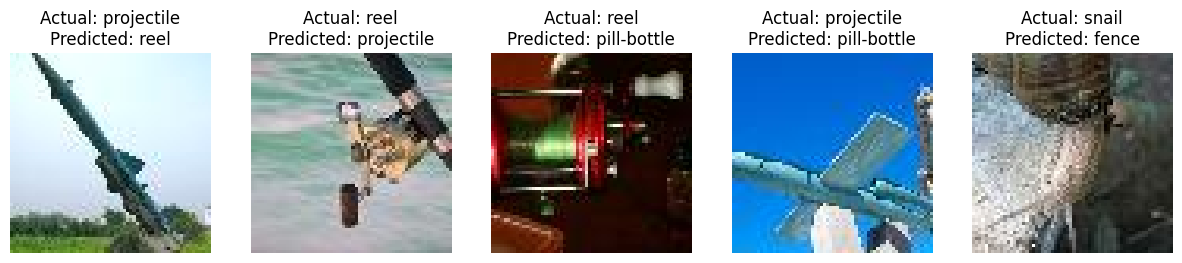

In [74]:
# Misclassified Images
misclassified_indices_custom_cnn = np.where(y_test_true_classes_custom_cnn != y_test_pred_classes_custom_cnn)[0]
random_misclassified_indices_custom_cnn = np.random.choice(misclassified_indices_custom_cnn, 5, replace=False)

plt.figure(figsize=(15, 5))
for i, index in enumerate(random_misclassified_indices_custom_cnn):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_test[index])
    plt.title(f"Actual: {classes[y_test_true_classes_custom_cnn[index]]}\nPredicted: {classes[y_test_pred_classes_custom_cnn[index]]}")
    plt.axis('off')
plt.show()

## Comparing the results

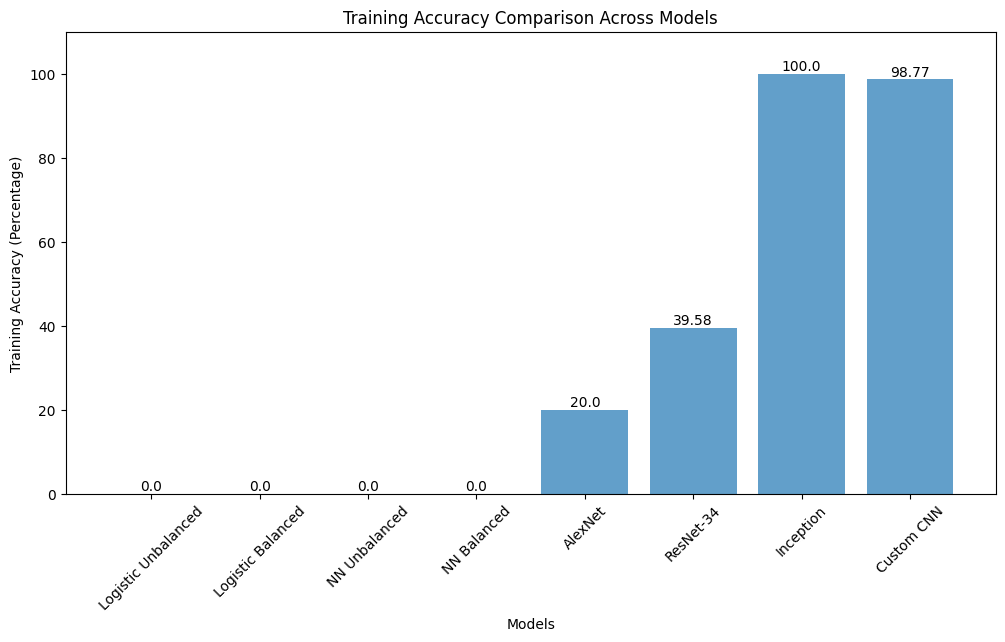

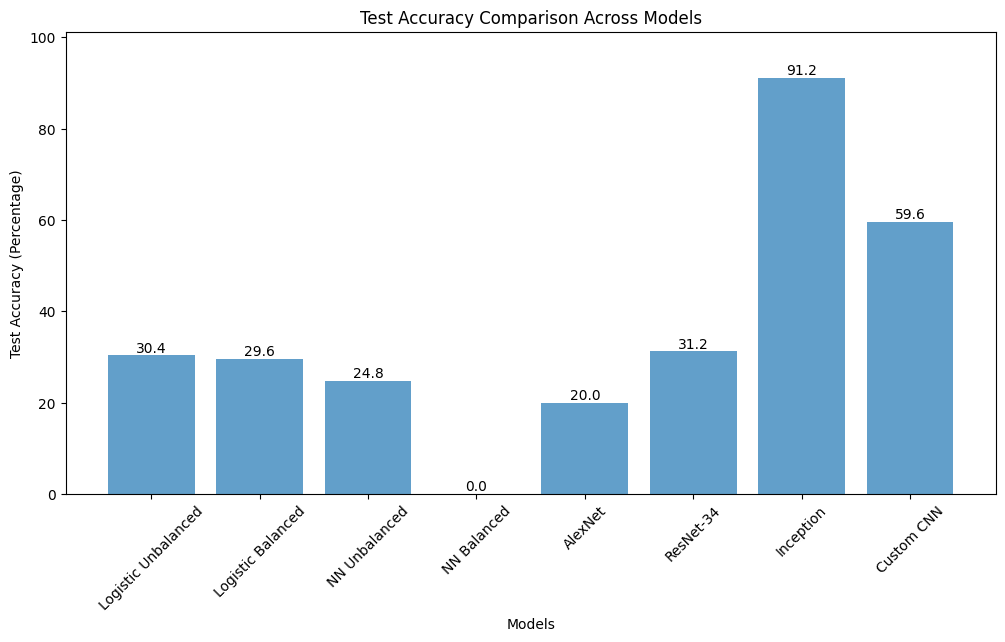

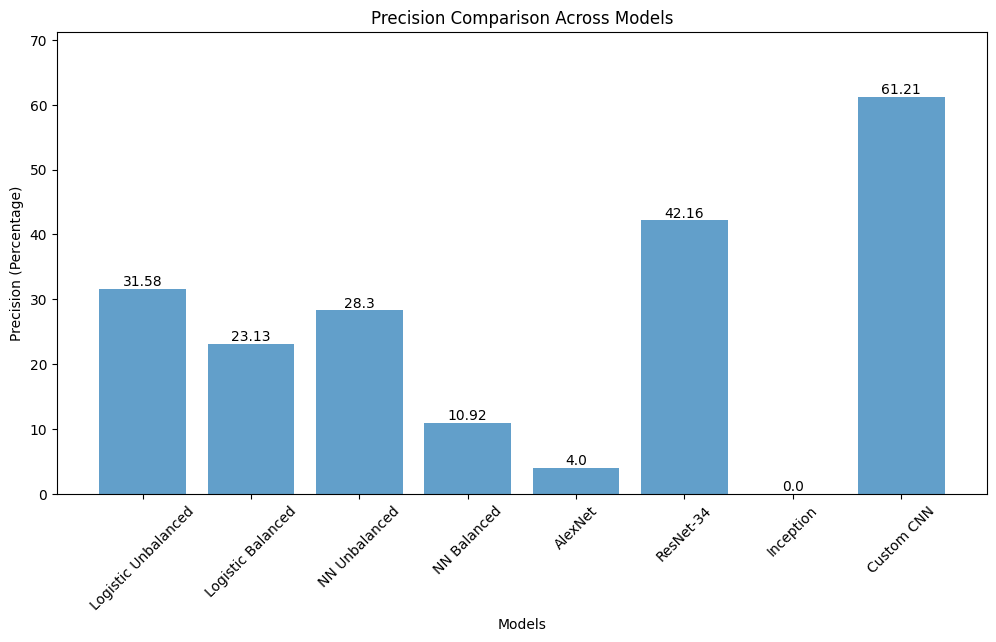

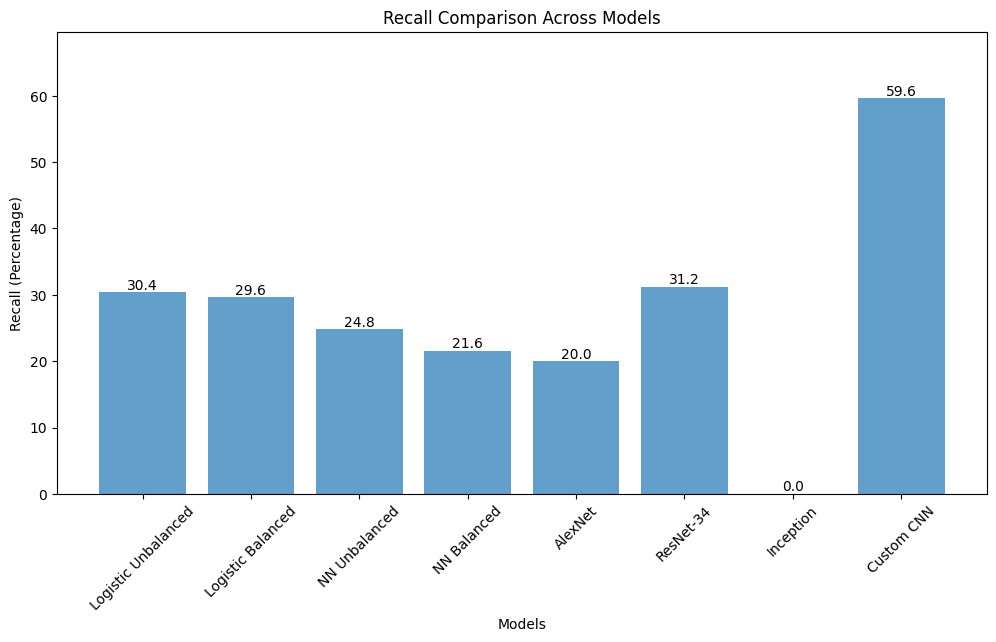

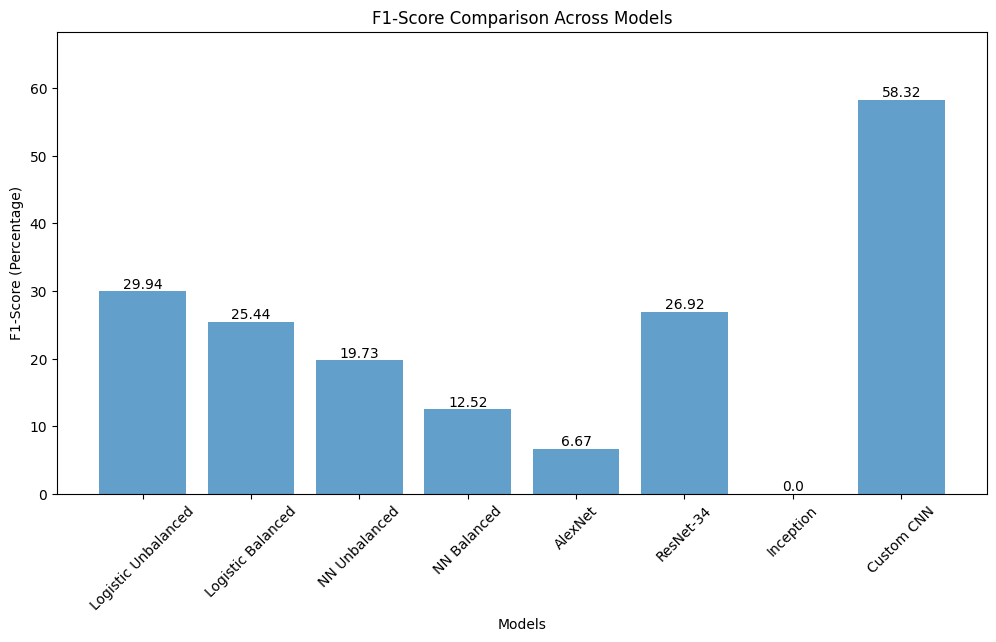

In [79]:
import matplotlib.pyplot as plt

# Function to plot a comparison graph for a given metric with values annotated on bars
def plot_metric_comparison(metric_name, models_metrics):
    labels = list(models_metrics.keys())
    values = [metrics.get(metric_name, 0) for metrics in models_metrics.values()]  # Get metric values

    plt.figure(figsize=(12, 6))
    bars = plt.bar(labels, values, alpha=0.7)
    plt.title(f'{metric_name} Comparison Across Models')
    plt.xlabel('Models')
    plt.ylabel(f'{metric_name} (Percentage)')
    plt.ylim(0, max(values) + 10)  # Adjust ylim to make room for annotations
    plt.xticks(rotation=45)  # Rotate labels for better readability

    # Annotate each bar with its value
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

    plt.show()

# Dictionary of model names and their corresponding metrics dictionaries
models_metrics = {
    "Logistic Unbalanced": logistic_unbalanced_metrics,
    "Logistic Balanced": logistic_balanced_metrics,
    "NN Unbalanced": nn_unbalanced_metrics,
    "NN Balanced": nn_balanced_metrics,
    "AlexNet": alexnet_metrics,
    "ResNet-34": resnet34_metrics,
    "Inception": inception_metrics,
    "Custom CNN": custom_cnn_metrics
}

# List of metrics to compare
metrics_to_compare = ["Training Accuracy", "Test Accuracy", "Precision", "Recall", "F1-Score"]

# Generate comparison plots for each metric
for metric in metrics_to_compare:
    plot_metric_comparison(metric, models_metrics)